In [1]:
from __future__ import print_function
import numpy as np 
import pandas as pd 
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


import IPython.display as ipd
import seaborn as sns

import warnings
import os
warnings.filterwarnings('ignore')

from torch import nn, optim
from torchvision import transforms, models, datasets

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
pwd

'/root/autodl-tmp/SER/speech-emotion-recognition-iemocap-master/code/models'

In [3]:
data_dir = '/root/autodl-tmp/SER/speech-emotion-recognition-iemocap-master/SER_new/IEMOCAP_image_data'
model_save_path = '/root/autodl-tmp/SER/speech-emotion-recognition-iemocap-master/SER_new/saved_models'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'

In [4]:
batch_size = 64

In [5]:
train_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
test_transforms = transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [6]:
trainset = datasets.ImageFolder(train_dir,transform=train_transforms)
testset = datasets.ImageFolder(test_dir,transform=test_transforms)

In [7]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

In [8]:
print(len(testloader.dataset))

880


In [9]:
print(len(trainloader.dataset))

3610


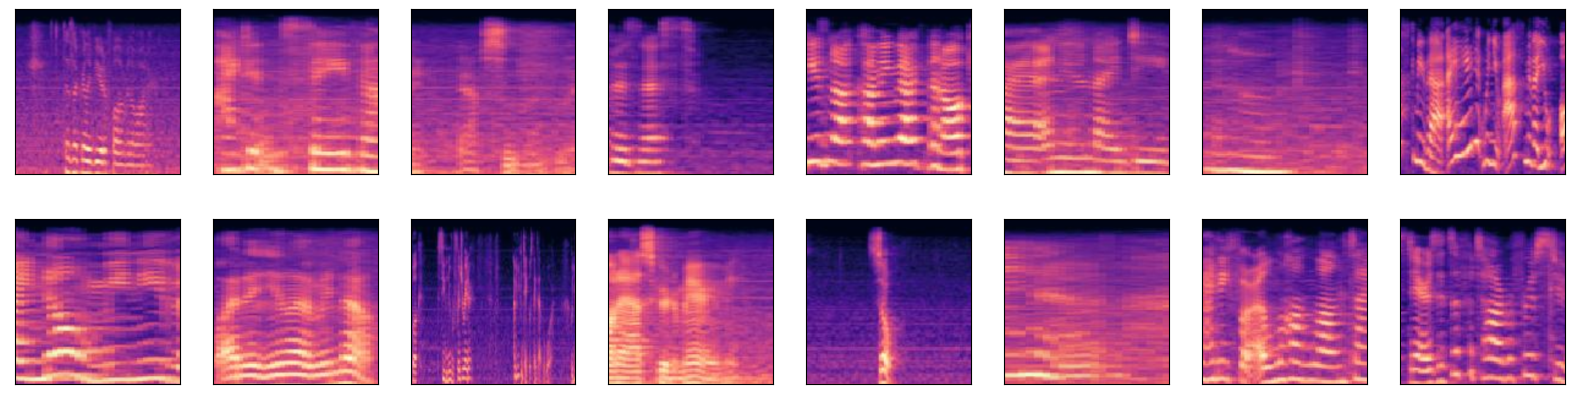

In [10]:
# def scale(x, out_range=(-1, 1)):
#     domain = np.min(x), np.max(x)
#     y = (x - (domain[1] + domain[0]) / 2) / (domain[1] - domain[0])
#     return y * (out_range[1] - out_range[0]) + (out_range[1] + out_range[0]) / 2

import numpy as np
import matplotlib.pyplot as plt

# scale 函数将数组归一化到 0 和 1 之间
def scale(x):
    return (x - np.min(x)) / np.ptp(x)

# imshow 函数用于显示图像
def imshow(img):
    img = scale(img)  # 将图像缩放到 [0, 1] 范围内，便于可视化
    plt.imshow(np.transpose(img, (1, 2, 0)))  # 调整通道顺序以匹配 Matplotlib 的显示格式

# 获取一个批次的数据
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy()  # 将图像张量转换为 numpy 数组，方便可视化处理

# 创建图像的显示窗口
fig = plt.figure(figsize=(20, 5))

# 循环显示 16 张图像
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16 // 2, idx + 1, xticks=[], yticks=[])  # 使用整数除法，确保列数为整数
    imshow(images[idx])  # 调用 imshow 函数显示图像

plt.show()  # 显示所有图像

In [11]:
trainiter = iter(trainloader)
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [12]:
torch.cuda.is_available()

True

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
model = models.resnet50(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
for param in model.parameters():
    param.requires_grad = False

In [16]:
# 更新 classifier，使其匹配 ResNet50 的输出
classifier = nn.Sequential(
    nn.Linear(2048, 200),  # 将输入调整为 2048 以匹配 ResNet50 的输出
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(200, 4)      # 输出类别数为 4
)
model.fc = classifier

In [17]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
# print(trainloader.dataset.classes)
print(trainloader.dataset.class_to_idx)

{'anger': 0, 'happiness': 1, 'neutral': 2, 'sadness': 3}


In [19]:
anger = 0
happiness = 0
neutral = 0
sadness = 0

for _, target in trainloader:
    labels = list(target.numpy())
    anger += len([x for x in labels if x == 0])
    happiness += len([x for x in labels if x == 1])
    neutral += len([x for x in labels if x == 2])
    sadness += len([x for x in labels if x == 3])
    
for _, target in testloader:
    labels = list(target.numpy())
    anger += len([x for x in labels if x == 0])
    happiness += len([x for x in labels if x == 1])
    neutral += len([x for x in labels if x == 2])
    sadness += len([x for x in labels if x == 3])

In [20]:
print("anger {} happiness {} neutral {} sadness {}".format(anger, happiness, neutral, sadness))

anger 1103 happiness 595 neutral 1708 sadness 1084


In [21]:
sample_weights = [1/anger, 1/happiness, 1/neutral, 1/sadness]
class_weights = torch.FloatTensor(sample_weights).cuda()
class_weights

tensor([0.0009, 0.0017, 0.0006, 0.0009], device='cuda:0')

In [22]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [23]:
# optimizer = optim.RMSprop(model.parameters(), lr=0.0003)
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
model = model.to(device)

In [24]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

23,918,636 total parameters.
410,604 training parameters.


In [25]:
labels = list(trainloader.dataset.class_to_idx.keys())
labels

['anger', 'happiness', 'neutral', 'sadness']

In [26]:
def plot_confusion_matrix(actual, predicted, labels):
    cm = confusion_matrix(actual, predicted, labels=labels)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, annot_kws={"size": 10}, fmt='.0f'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
    plt.show()

In [27]:
label_to_class = {value: key for key, value in trainloader.dataset.class_to_idx.items()}
label_to_class

{0: 'anger', 1: 'happiness', 2: 'neutral', 3: 'sadness'}

In [28]:
def train(epoch, model):
    model.train()
    correct_train = 0
    train_loss = 0
    train_acc = 0
    
    
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        
        # zero the gradient, forward, backward and running pytorch rhythm
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        # get the label of prediction
        pred = torch.max(output.data, 1)[1]
        correct_train += pred.eq(target.data.view_as(pred)).cpu().sum()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\n'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))
    
    train_loss /= len(trainloader.dataset)
    train_acc = 100. * correct_train / len(trainloader.dataset)
    print('\nTrain set: Average loss: {:.4f}\n'.format(train_loss))
    print('\nTrain Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct_train, len(trainloader.dataset), 100. * correct_train / len(trainloader.dataset)))
    
    return train_loss, int(train_acc.numpy())
            

In [29]:
def test(model):
    model.eval()
    test_loss = 0
    test_acc = 0
    correct = 0
    history_test = []

    pred_model = []
    actual = []

    for data, target in testloader:
        data, target = data.to(device), target.to(device)

        # output from model
        output = model(data)

        # sum total loss
        test_loss += criterion(output, target).item()

        # get the label of prediction
        pred = torch.max(output.data, 1)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        pred_model.append(pred.cpu().numpy())
        actual.append(target.data.cpu().numpy())


    test_loss /= len(testloader.dataset)
    test_acc = 100. * correct / len(testloader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))


    pred_with_label = [label_to_class[label] for label in list(np.concatenate(pred_model))]
    actual_with_label = [label_to_class[label] for label in list(np.concatenate(actual))]

    plot_confusion_matrix(actual_with_label, pred_with_label, labels)

    print('\n Classification Report \n {} \n'.format(classification_report(actual_with_label, pred_with_label)))

    return test_loss, int(test_acc.numpy())

Train Epoch: 1 [0/3610 (0%)]	Loss: 1.420261

Train Epoch: 1 [640/3610 (18%)]	Loss: 1.407397

Train Epoch: 1 [1280/3610 (35%)]	Loss: 1.371029

Train Epoch: 1 [1920/3610 (53%)]	Loss: 1.349423

Train Epoch: 1 [2560/3610 (70%)]	Loss: 1.397744

Train Epoch: 1 [3200/3610 (88%)]	Loss: 1.363724


Train set: Average loss: 0.0218


Train Accuracy: 993/3610 (28%)


Test set: Average loss: 0.0215, Accuracy: 375/880 (43%)



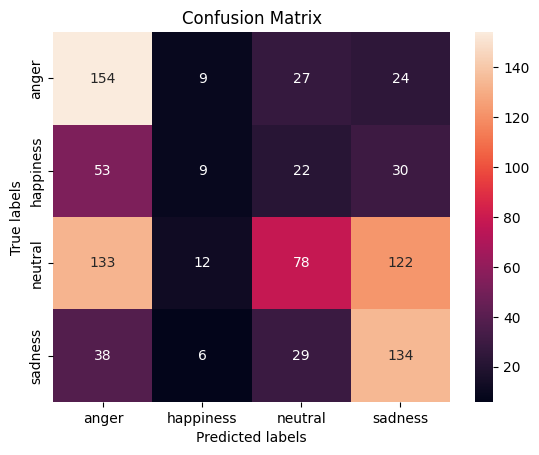


 Classification Report 
               precision    recall  f1-score   support

       anger       0.41      0.72      0.52       214
   happiness       0.25      0.08      0.12       114
     neutral       0.50      0.23      0.31       345
     sadness       0.43      0.65      0.52       207

    accuracy                           0.43       880
   macro avg       0.40      0.42      0.37       880
weighted avg       0.43      0.43      0.39       880
 

Train Epoch: 2 [0/3610 (0%)]	Loss: 1.373655

Train Epoch: 2 [640/3610 (18%)]	Loss: 1.355171

Train Epoch: 2 [1280/3610 (35%)]	Loss: 1.370916

Train Epoch: 2 [1920/3610 (53%)]	Loss: 1.323611

Train Epoch: 2 [2560/3610 (70%)]	Loss: 1.313617

Train Epoch: 2 [3200/3610 (88%)]	Loss: 1.316130


Train set: Average loss: 0.0212


Train Accuracy: 1347/3610 (37%)


Test set: Average loss: 0.0210, Accuracy: 419/880 (48%)



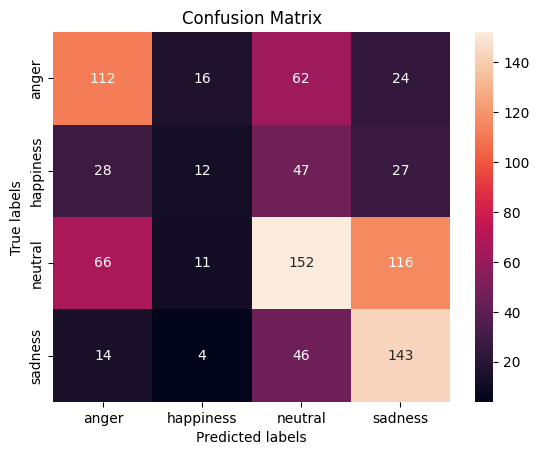


 Classification Report 
               precision    recall  f1-score   support

       anger       0.51      0.52      0.52       214
   happiness       0.28      0.11      0.15       114
     neutral       0.50      0.44      0.47       345
     sadness       0.46      0.69      0.55       207

    accuracy                           0.48       880
   macro avg       0.44      0.44      0.42       880
weighted avg       0.46      0.48      0.46       880
 

Train Epoch: 3 [0/3610 (0%)]	Loss: 1.308591

Train Epoch: 3 [640/3610 (18%)]	Loss: 1.319816

Train Epoch: 3 [1280/3610 (35%)]	Loss: 1.314553

Train Epoch: 3 [1920/3610 (53%)]	Loss: 1.321436

Train Epoch: 3 [2560/3610 (70%)]	Loss: 1.328306

Train Epoch: 3 [3200/3610 (88%)]	Loss: 1.353306


Train set: Average loss: 0.0209


Train Accuracy: 1512/3610 (42%)


Test set: Average loss: 0.0209, Accuracy: 391/880 (44%)



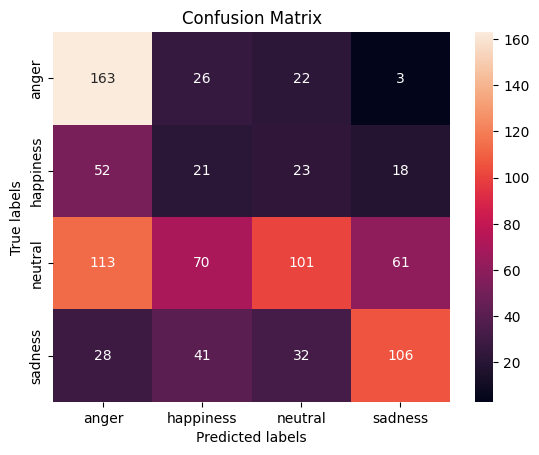


 Classification Report 
               precision    recall  f1-score   support

       anger       0.46      0.76      0.57       214
   happiness       0.13      0.18      0.15       114
     neutral       0.57      0.29      0.39       345
     sadness       0.56      0.51      0.54       207

    accuracy                           0.44       880
   macro avg       0.43      0.44      0.41       880
weighted avg       0.48      0.44      0.44       880
 

Train Epoch: 4 [0/3610 (0%)]	Loss: 1.317603

Train Epoch: 4 [640/3610 (18%)]	Loss: 1.301549

Train Epoch: 4 [1280/3610 (35%)]	Loss: 1.272960

Train Epoch: 4 [1920/3610 (53%)]	Loss: 1.316151

Train Epoch: 4 [2560/3610 (70%)]	Loss: 1.316529

Train Epoch: 4 [3200/3610 (88%)]	Loss: 1.224611


Train set: Average loss: 0.0205


Train Accuracy: 1519/3610 (42%)


Test set: Average loss: 0.0203, Accuracy: 412/880 (47%)



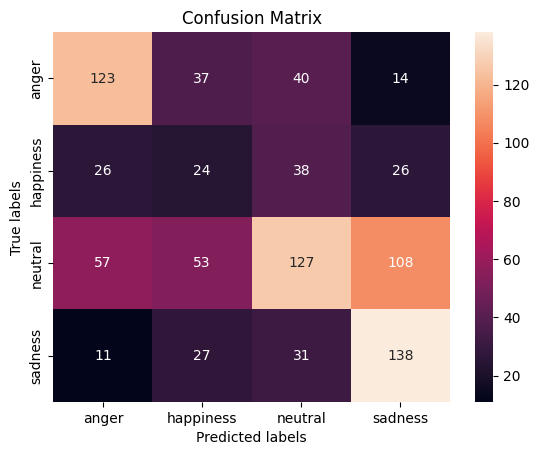


 Classification Report 
               precision    recall  f1-score   support

       anger       0.57      0.57      0.57       214
   happiness       0.17      0.21      0.19       114
     neutral       0.54      0.37      0.44       345
     sadness       0.48      0.67      0.56       207

    accuracy                           0.47       880
   macro avg       0.44      0.46      0.44       880
weighted avg       0.48      0.47      0.47       880
 

Train Epoch: 5 [0/3610 (0%)]	Loss: 1.275058

Train Epoch: 5 [640/3610 (18%)]	Loss: 1.261848

Train Epoch: 5 [1280/3610 (35%)]	Loss: 1.248590

Train Epoch: 5 [1920/3610 (53%)]	Loss: 1.225657

Train Epoch: 5 [2560/3610 (70%)]	Loss: 1.275438

Train Epoch: 5 [3200/3610 (88%)]	Loss: 1.303777


Train set: Average loss: 0.0201


Train Accuracy: 1589/3610 (44%)


Test set: Average loss: 0.0201, Accuracy: 403/880 (46%)



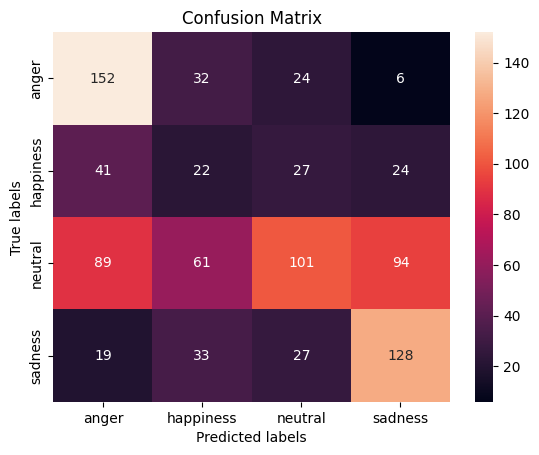


 Classification Report 
               precision    recall  f1-score   support

       anger       0.50      0.71      0.59       214
   happiness       0.15      0.19      0.17       114
     neutral       0.56      0.29      0.39       345
     sadness       0.51      0.62      0.56       207

    accuracy                           0.46       880
   macro avg       0.43      0.45      0.43       880
weighted avg       0.48      0.46      0.45       880
 

Train Epoch: 6 [0/3610 (0%)]	Loss: 1.268370

Train Epoch: 6 [640/3610 (18%)]	Loss: 1.219369

Train Epoch: 6 [1280/3610 (35%)]	Loss: 1.240237

Train Epoch: 6 [1920/3610 (53%)]	Loss: 1.299507

Train Epoch: 6 [2560/3610 (70%)]	Loss: 1.166101

Train Epoch: 6 [3200/3610 (88%)]	Loss: 1.269994


Train set: Average loss: 0.0197


Train Accuracy: 1671/3610 (46%)


Test set: Average loss: 0.0195, Accuracy: 448/880 (51%)



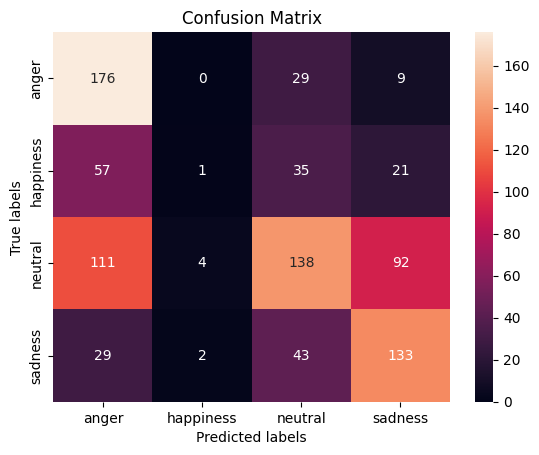


 Classification Report 
               precision    recall  f1-score   support

       anger       0.47      0.82      0.60       214
   happiness       0.14      0.01      0.02       114
     neutral       0.56      0.40      0.47       345
     sadness       0.52      0.64      0.58       207

    accuracy                           0.51       880
   macro avg       0.42      0.47      0.41       880
weighted avg       0.48      0.51      0.47       880
 

Train Epoch: 7 [0/3610 (0%)]	Loss: 1.274710

Train Epoch: 7 [640/3610 (18%)]	Loss: 1.201675

Train Epoch: 7 [1280/3610 (35%)]	Loss: 1.197547

Train Epoch: 7 [1920/3610 (53%)]	Loss: 1.284128

Train Epoch: 7 [2560/3610 (70%)]	Loss: 1.226591

Train Epoch: 7 [3200/3610 (88%)]	Loss: 1.297252


Train set: Average loss: 0.0195


Train Accuracy: 1707/3610 (47%)


Test set: Average loss: 0.0192, Accuracy: 438/880 (50%)



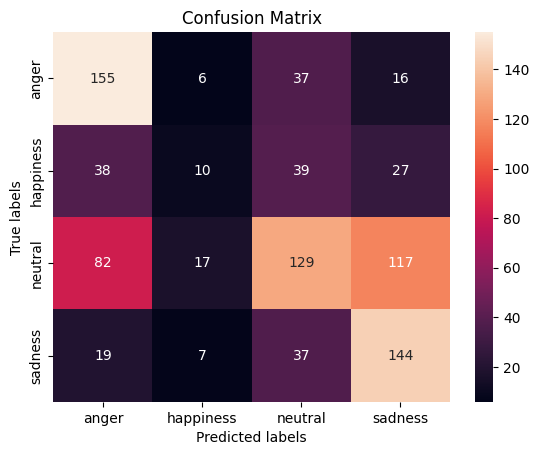


 Classification Report 
               precision    recall  f1-score   support

       anger       0.53      0.72      0.61       214
   happiness       0.25      0.09      0.13       114
     neutral       0.53      0.37      0.44       345
     sadness       0.47      0.70      0.56       207

    accuracy                           0.50       880
   macro avg       0.45      0.47      0.44       880
weighted avg       0.48      0.50      0.47       880
 

Train Epoch: 8 [0/3610 (0%)]	Loss: 1.234622

Train Epoch: 8 [640/3610 (18%)]	Loss: 1.156015

Train Epoch: 8 [1280/3610 (35%)]	Loss: 1.234023

Train Epoch: 8 [1920/3610 (53%)]	Loss: 1.234120

Train Epoch: 8 [2560/3610 (70%)]	Loss: 1.188195

Train Epoch: 8 [3200/3610 (88%)]	Loss: 1.271019


Train set: Average loss: 0.0191


Train Accuracy: 1781/3610 (49%)


Test set: Average loss: 0.0193, Accuracy: 413/880 (47%)



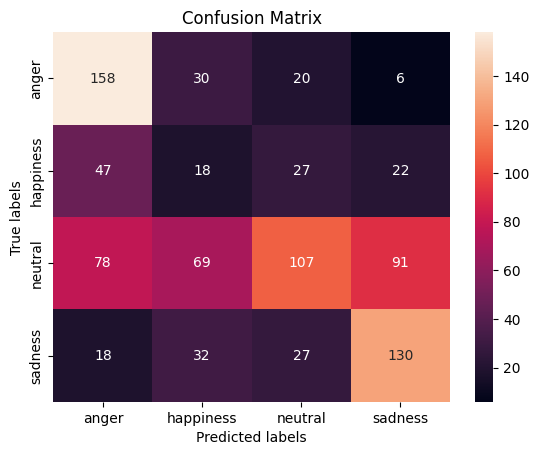


 Classification Report 
               precision    recall  f1-score   support

       anger       0.52      0.74      0.61       214
   happiness       0.12      0.16      0.14       114
     neutral       0.59      0.31      0.41       345
     sadness       0.52      0.63      0.57       207

    accuracy                           0.47       880
   macro avg       0.44      0.46      0.43       880
weighted avg       0.50      0.47      0.46       880
 

Train Epoch: 9 [0/3610 (0%)]	Loss: 1.164810

Train Epoch: 9 [640/3610 (18%)]	Loss: 1.222318

Train Epoch: 9 [1280/3610 (35%)]	Loss: 1.194490

Train Epoch: 9 [1920/3610 (53%)]	Loss: 1.144054

Train Epoch: 9 [2560/3610 (70%)]	Loss: 1.181123

Train Epoch: 9 [3200/3610 (88%)]	Loss: 1.210748


Train set: Average loss: 0.0190


Train Accuracy: 1785/3610 (49%)


Test set: Average loss: 0.0193, Accuracy: 407/880 (46%)



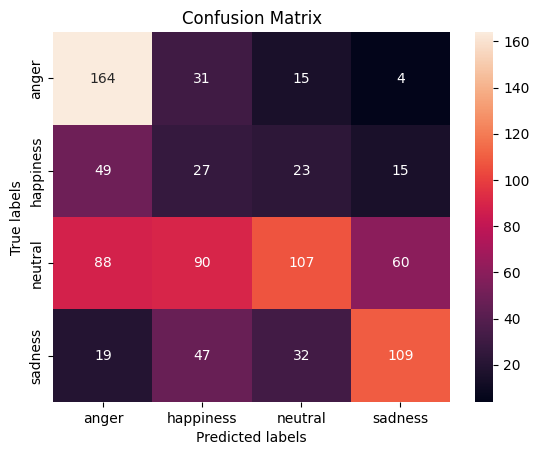


 Classification Report 
               precision    recall  f1-score   support

       anger       0.51      0.77      0.61       214
   happiness       0.14      0.24      0.17       114
     neutral       0.60      0.31      0.41       345
     sadness       0.58      0.53      0.55       207

    accuracy                           0.46       880
   macro avg       0.46      0.46      0.44       880
weighted avg       0.52      0.46      0.46       880
 

Train Epoch: 10 [0/3610 (0%)]	Loss: 1.189531

Train Epoch: 10 [640/3610 (18%)]	Loss: 1.209133

Train Epoch: 10 [1280/3610 (35%)]	Loss: 1.174306

Train Epoch: 10 [1920/3610 (53%)]	Loss: 1.218550

Train Epoch: 10 [2560/3610 (70%)]	Loss: 1.167757

Train Epoch: 10 [3200/3610 (88%)]	Loss: 1.189262


Train set: Average loss: 0.0189


Train Accuracy: 1702/3610 (47%)


Test set: Average loss: 0.0189, Accuracy: 423/880 (48%)



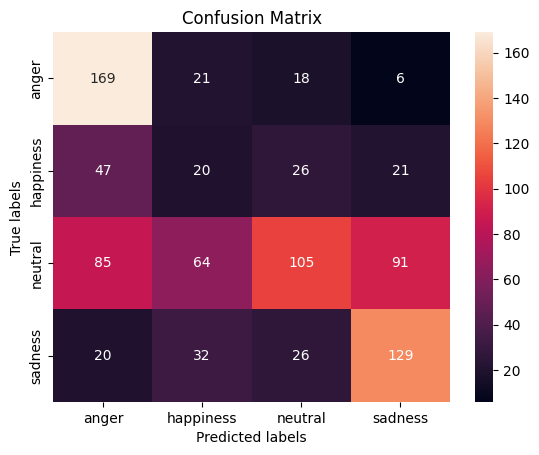


 Classification Report 
               precision    recall  f1-score   support

       anger       0.53      0.79      0.63       214
   happiness       0.15      0.18      0.16       114
     neutral       0.60      0.30      0.40       345
     sadness       0.52      0.62      0.57       207

    accuracy                           0.48       880
   macro avg       0.45      0.47      0.44       880
weighted avg       0.51      0.48      0.47       880
 

Train Epoch: 11 [0/3610 (0%)]	Loss: 1.197255

Train Epoch: 11 [640/3610 (18%)]	Loss: 1.210995

Train Epoch: 11 [1280/3610 (35%)]	Loss: 1.191808

Train Epoch: 11 [1920/3610 (53%)]	Loss: 1.167950

Train Epoch: 11 [2560/3610 (70%)]	Loss: 1.237594

Train Epoch: 11 [3200/3610 (88%)]	Loss: 1.141457


Train set: Average loss: 0.0187


Train Accuracy: 1758/3610 (49%)


Test set: Average loss: 0.0185, Accuracy: 450/880 (51%)



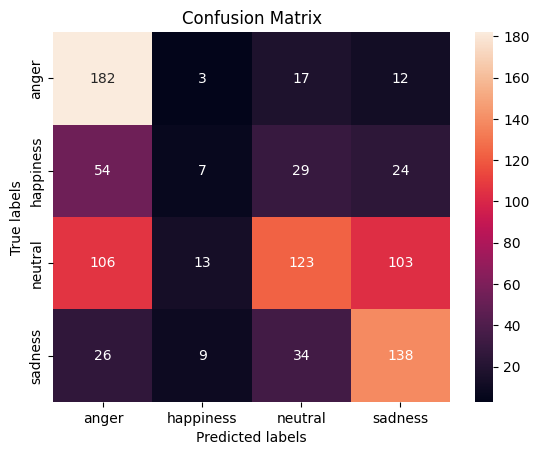


 Classification Report 
               precision    recall  f1-score   support

       anger       0.49      0.85      0.63       214
   happiness       0.22      0.06      0.10       114
     neutral       0.61      0.36      0.45       345
     sadness       0.50      0.67      0.57       207

    accuracy                           0.51       880
   macro avg       0.45      0.48      0.44       880
weighted avg       0.50      0.51      0.47       880
 

Train Epoch: 12 [0/3610 (0%)]	Loss: 1.199711

Train Epoch: 12 [640/3610 (18%)]	Loss: 1.209065

Train Epoch: 12 [1280/3610 (35%)]	Loss: 1.214206

Train Epoch: 12 [1920/3610 (53%)]	Loss: 1.140906

Train Epoch: 12 [2560/3610 (70%)]	Loss: 1.175269

Train Epoch: 12 [3200/3610 (88%)]	Loss: 1.162250


Train set: Average loss: 0.0185


Train Accuracy: 1818/3610 (50%)


Test set: Average loss: 0.0185, Accuracy: 442/880 (50%)



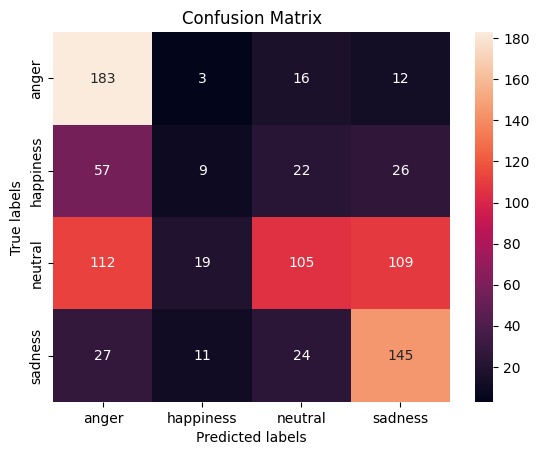


 Classification Report 
               precision    recall  f1-score   support

       anger       0.48      0.86      0.62       214
   happiness       0.21      0.08      0.12       114
     neutral       0.63      0.30      0.41       345
     sadness       0.50      0.70      0.58       207

    accuracy                           0.50       880
   macro avg       0.46      0.48      0.43       880
weighted avg       0.51      0.50      0.46       880
 

Train Epoch: 13 [0/3610 (0%)]	Loss: 1.260319

Train Epoch: 13 [640/3610 (18%)]	Loss: 1.149443

Train Epoch: 13 [1280/3610 (35%)]	Loss: 1.162861

Train Epoch: 13 [1920/3610 (53%)]	Loss: 1.157643

Train Epoch: 13 [2560/3610 (70%)]	Loss: 1.243222

Train Epoch: 13 [3200/3610 (88%)]	Loss: 1.239555


Train set: Average loss: 0.0185


Train Accuracy: 1816/3610 (50%)


Test set: Average loss: 0.0183, Accuracy: 456/880 (52%)



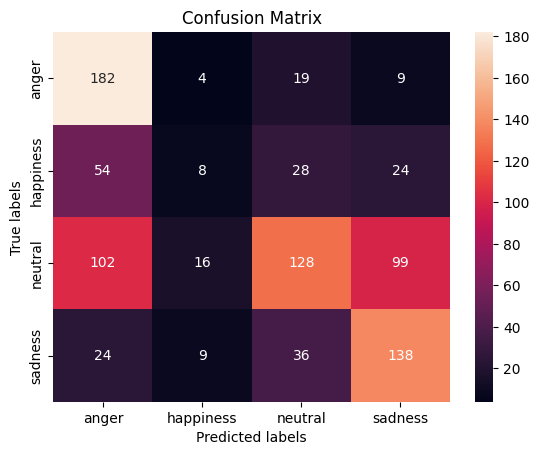


 Classification Report 
               precision    recall  f1-score   support

       anger       0.50      0.85      0.63       214
   happiness       0.22      0.07      0.11       114
     neutral       0.61      0.37      0.46       345
     sadness       0.51      0.67      0.58       207

    accuracy                           0.52       880
   macro avg       0.46      0.49      0.44       880
weighted avg       0.51      0.52      0.48       880
 

Train Epoch: 14 [0/3610 (0%)]	Loss: 1.133069

Train Epoch: 14 [640/3610 (18%)]	Loss: 1.215880

Train Epoch: 14 [1280/3610 (35%)]	Loss: 1.231323

Train Epoch: 14 [1920/3610 (53%)]	Loss: 1.248639

Train Epoch: 14 [2560/3610 (70%)]	Loss: 1.106912

Train Epoch: 14 [3200/3610 (88%)]	Loss: 1.232264


Train set: Average loss: 0.0183


Train Accuracy: 1837/3610 (51%)


Test set: Average loss: 0.0185, Accuracy: 435/880 (49%)



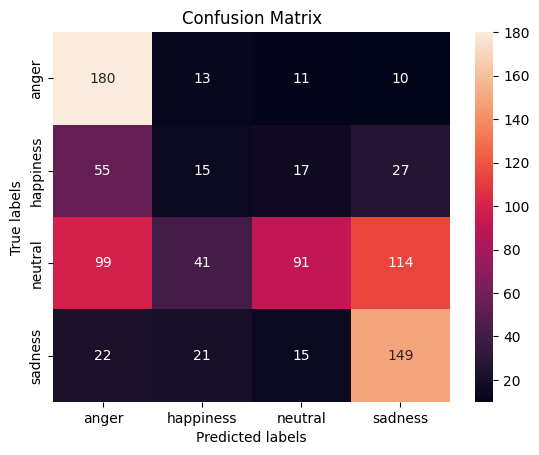


 Classification Report 
               precision    recall  f1-score   support

       anger       0.51      0.84      0.63       214
   happiness       0.17      0.13      0.15       114
     neutral       0.68      0.26      0.38       345
     sadness       0.50      0.72      0.59       207

    accuracy                           0.49       880
   macro avg       0.46      0.49      0.44       880
weighted avg       0.53      0.49      0.46       880
 

Train Epoch: 15 [0/3610 (0%)]	Loss: 1.107154

Train Epoch: 15 [640/3610 (18%)]	Loss: 1.233851

Train Epoch: 15 [1280/3610 (35%)]	Loss: 1.087095

Train Epoch: 15 [1920/3610 (53%)]	Loss: 1.155560

Train Epoch: 15 [2560/3610 (70%)]	Loss: 1.241379

Train Epoch: 15 [3200/3610 (88%)]	Loss: 1.158865


Train set: Average loss: 0.0182


Train Accuracy: 1838/3610 (51%)


Test set: Average loss: 0.0183, Accuracy: 444/880 (50%)



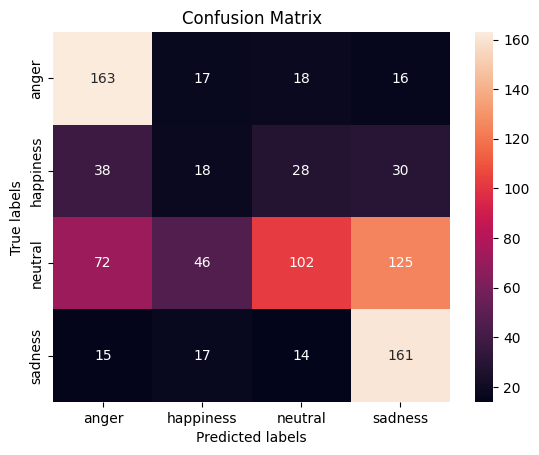


 Classification Report 
               precision    recall  f1-score   support

       anger       0.57      0.76      0.65       214
   happiness       0.18      0.16      0.17       114
     neutral       0.63      0.30      0.40       345
     sadness       0.48      0.78      0.60       207

    accuracy                           0.50       880
   macro avg       0.47      0.50      0.45       880
weighted avg       0.52      0.50      0.48       880
 

Train Epoch: 16 [0/3610 (0%)]	Loss: 1.072763

Train Epoch: 16 [640/3610 (18%)]	Loss: 1.170336

Train Epoch: 16 [1280/3610 (35%)]	Loss: 1.062890

Train Epoch: 16 [1920/3610 (53%)]	Loss: 1.221023

Train Epoch: 16 [2560/3610 (70%)]	Loss: 1.023251

Train Epoch: 16 [3200/3610 (88%)]	Loss: 1.001133


Train set: Average loss: 0.0182


Train Accuracy: 1832/3610 (51%)


Test set: Average loss: 0.0180, Accuracy: 464/880 (53%)



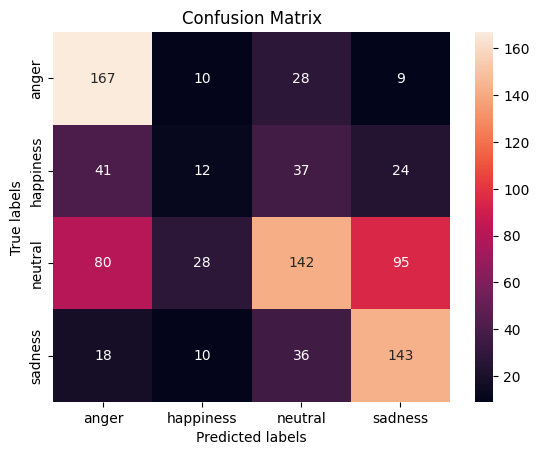


 Classification Report 
               precision    recall  f1-score   support

       anger       0.55      0.78      0.64       214
   happiness       0.20      0.11      0.14       114
     neutral       0.58      0.41      0.48       345
     sadness       0.53      0.69      0.60       207

    accuracy                           0.53       880
   macro avg       0.46      0.50      0.47       880
weighted avg       0.51      0.53      0.50       880
 

Train Epoch: 17 [0/3610 (0%)]	Loss: 1.033168

Train Epoch: 17 [640/3610 (18%)]	Loss: 0.905743

Train Epoch: 17 [1280/3610 (35%)]	Loss: 1.140357

Train Epoch: 17 [1920/3610 (53%)]	Loss: 1.204728

Train Epoch: 17 [2560/3610 (70%)]	Loss: 1.140437

Train Epoch: 17 [3200/3610 (88%)]	Loss: 1.191348


Train set: Average loss: 0.0180


Train Accuracy: 1867/3610 (52%)


Test set: Average loss: 0.0182, Accuracy: 448/880 (51%)



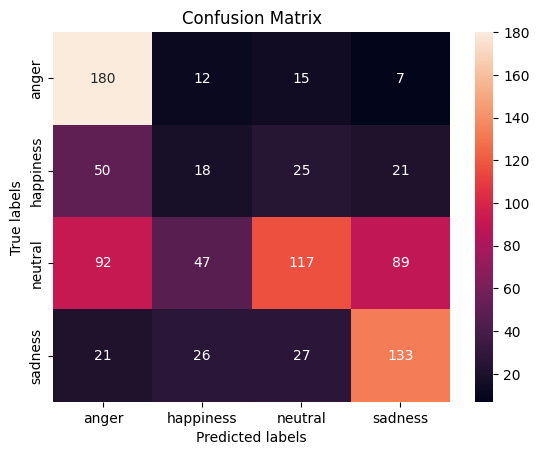


 Classification Report 
               precision    recall  f1-score   support

       anger       0.52      0.84      0.65       214
   happiness       0.17      0.16      0.17       114
     neutral       0.64      0.34      0.44       345
     sadness       0.53      0.64      0.58       207

    accuracy                           0.51       880
   macro avg       0.47      0.50      0.46       880
weighted avg       0.52      0.51      0.49       880
 

Train Epoch: 18 [0/3610 (0%)]	Loss: 1.143723

Train Epoch: 18 [640/3610 (18%)]	Loss: 1.185057

Train Epoch: 18 [1280/3610 (35%)]	Loss: 1.084856

Train Epoch: 18 [1920/3610 (53%)]	Loss: 1.006142

Train Epoch: 18 [2560/3610 (70%)]	Loss: 1.158431

Train Epoch: 18 [3200/3610 (88%)]	Loss: 1.000379


Train set: Average loss: 0.0180


Train Accuracy: 1881/3610 (52%)


Test set: Average loss: 0.0182, Accuracy: 446/880 (51%)



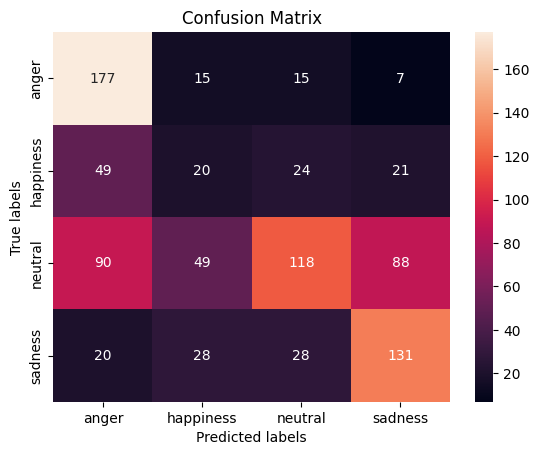


 Classification Report 
               precision    recall  f1-score   support

       anger       0.53      0.83      0.64       214
   happiness       0.18      0.18      0.18       114
     neutral       0.64      0.34      0.45       345
     sadness       0.53      0.63      0.58       207

    accuracy                           0.51       880
   macro avg       0.47      0.49      0.46       880
weighted avg       0.53      0.51      0.49       880
 

Train Epoch: 19 [0/3610 (0%)]	Loss: 0.982831

Train Epoch: 19 [640/3610 (18%)]	Loss: 1.107635

Train Epoch: 19 [1280/3610 (35%)]	Loss: 1.097352

Train Epoch: 19 [1920/3610 (53%)]	Loss: 1.125626

Train Epoch: 19 [2560/3610 (70%)]	Loss: 1.066183

Train Epoch: 19 [3200/3610 (88%)]	Loss: 1.139673


Train set: Average loss: 0.0178


Train Accuracy: 1873/3610 (52%)


Test set: Average loss: 0.0181, Accuracy: 447/880 (51%)



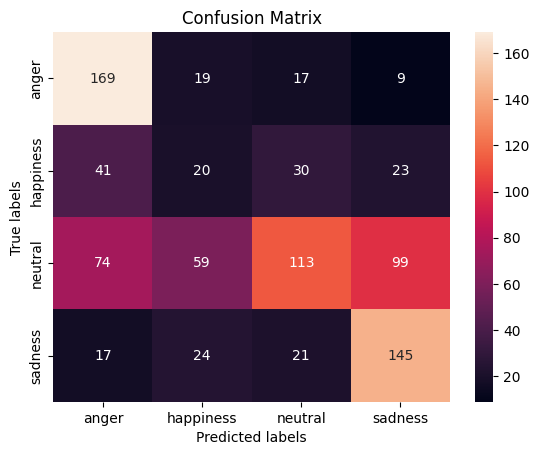


 Classification Report 
               precision    recall  f1-score   support

       anger       0.56      0.79      0.66       214
   happiness       0.16      0.18      0.17       114
     neutral       0.62      0.33      0.43       345
     sadness       0.53      0.70      0.60       207

    accuracy                           0.51       880
   macro avg       0.47      0.50      0.46       880
weighted avg       0.53      0.51      0.49       880
 

Train Epoch: 20 [0/3610 (0%)]	Loss: 1.134634

Train Epoch: 20 [640/3610 (18%)]	Loss: 1.049304

Train Epoch: 20 [1280/3610 (35%)]	Loss: 1.075679

Train Epoch: 20 [1920/3610 (53%)]	Loss: 1.070689

Train Epoch: 20 [2560/3610 (70%)]	Loss: 1.109778

Train Epoch: 20 [3200/3610 (88%)]	Loss: 1.100403


Train set: Average loss: 0.0177


Train Accuracy: 1900/3610 (53%)


Test set: Average loss: 0.0181, Accuracy: 433/880 (49%)



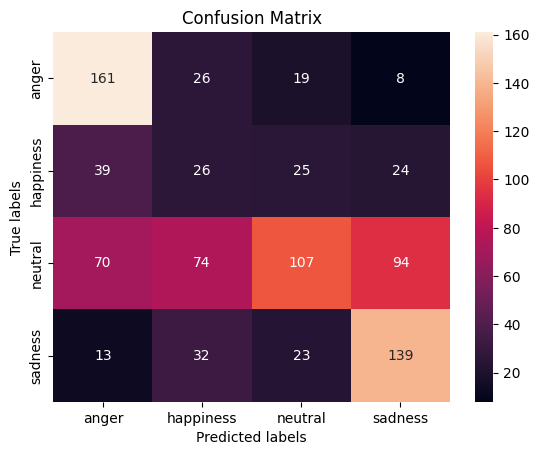


 Classification Report 
               precision    recall  f1-score   support

       anger       0.57      0.75      0.65       214
   happiness       0.16      0.23      0.19       114
     neutral       0.61      0.31      0.41       345
     sadness       0.52      0.67      0.59       207

    accuracy                           0.49       880
   macro avg       0.47      0.49      0.46       880
weighted avg       0.52      0.49      0.48       880
 

Train Epoch: 21 [0/3610 (0%)]	Loss: 1.185064

Train Epoch: 21 [640/3610 (18%)]	Loss: 1.078825

Train Epoch: 21 [1280/3610 (35%)]	Loss: 1.077242

Train Epoch: 21 [1920/3610 (53%)]	Loss: 1.140235

Train Epoch: 21 [2560/3610 (70%)]	Loss: 1.249491

Train Epoch: 21 [3200/3610 (88%)]	Loss: 1.061691


Train set: Average loss: 0.0177


Train Accuracy: 1916/3610 (53%)


Test set: Average loss: 0.0183, Accuracy: 416/880 (47%)



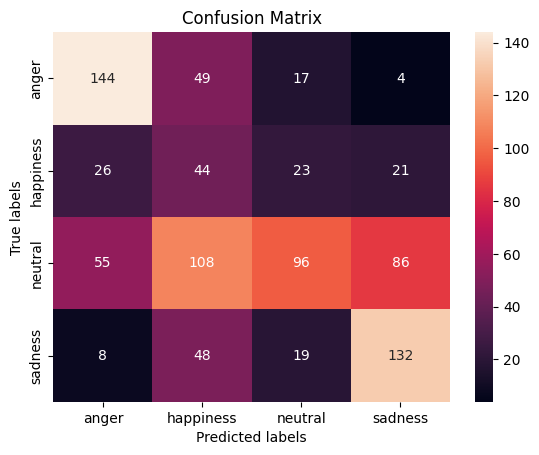


 Classification Report 
               precision    recall  f1-score   support

       anger       0.62      0.67      0.64       214
   happiness       0.18      0.39      0.24       114
     neutral       0.62      0.28      0.38       345
     sadness       0.54      0.64      0.59       207

    accuracy                           0.47       880
   macro avg       0.49      0.49      0.46       880
weighted avg       0.54      0.47      0.48       880
 

Train Epoch: 22 [0/3610 (0%)]	Loss: 1.020634

Train Epoch: 22 [640/3610 (18%)]	Loss: 1.108637

Train Epoch: 22 [1280/3610 (35%)]	Loss: 1.075846

Train Epoch: 22 [1920/3610 (53%)]	Loss: 1.129012

Train Epoch: 22 [2560/3610 (70%)]	Loss: 1.148104

Train Epoch: 22 [3200/3610 (88%)]	Loss: 1.064713


Train set: Average loss: 0.0177


Train Accuracy: 1871/3610 (52%)


Test set: Average loss: 0.0181, Accuracy: 437/880 (50%)



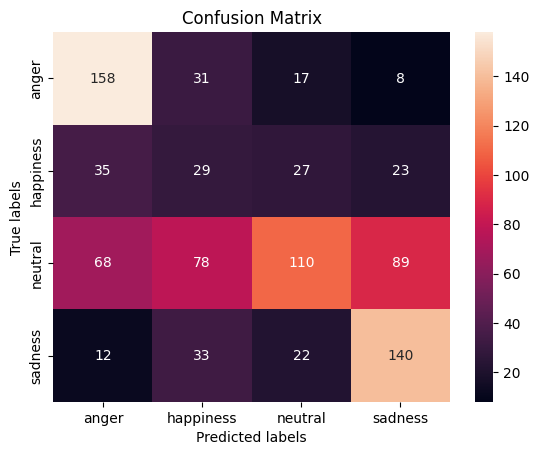


 Classification Report 
               precision    recall  f1-score   support

       anger       0.58      0.74      0.65       214
   happiness       0.17      0.25      0.20       114
     neutral       0.62      0.32      0.42       345
     sadness       0.54      0.68      0.60       207

    accuracy                           0.50       880
   macro avg       0.48      0.50      0.47       880
weighted avg       0.53      0.50      0.49       880
 

Train Epoch: 23 [0/3610 (0%)]	Loss: 1.105404

Train Epoch: 23 [640/3610 (18%)]	Loss: 1.067445

Train Epoch: 23 [1280/3610 (35%)]	Loss: 1.060707

Train Epoch: 23 [1920/3610 (53%)]	Loss: 1.071123

Train Epoch: 23 [2560/3610 (70%)]	Loss: 1.177685

Train Epoch: 23 [3200/3610 (88%)]	Loss: 1.099415


Train set: Average loss: 0.0175


Train Accuracy: 1920/3610 (53%)


Test set: Average loss: 0.0177, Accuracy: 460/880 (52%)



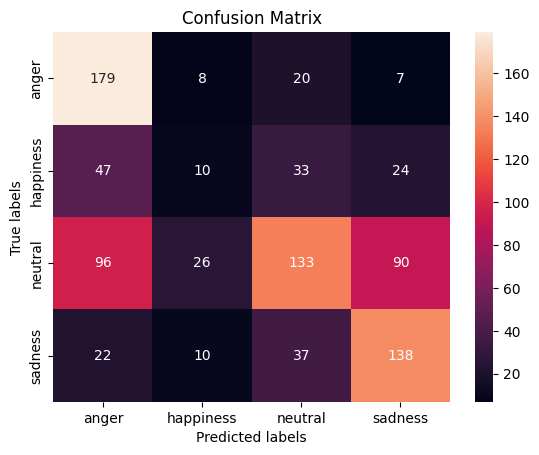


 Classification Report 
               precision    recall  f1-score   support

       anger       0.52      0.84      0.64       214
   happiness       0.19      0.09      0.12       114
     neutral       0.60      0.39      0.47       345
     sadness       0.53      0.67      0.59       207

    accuracy                           0.52       880
   macro avg       0.46      0.49      0.46       880
weighted avg       0.51      0.52      0.49       880
 

Train Epoch: 24 [0/3610 (0%)]	Loss: 1.324810

Train Epoch: 24 [640/3610 (18%)]	Loss: 1.206367

Train Epoch: 24 [1280/3610 (35%)]	Loss: 0.946768

Train Epoch: 24 [1920/3610 (53%)]	Loss: 1.208565

Train Epoch: 24 [2560/3610 (70%)]	Loss: 1.182866

Train Epoch: 24 [3200/3610 (88%)]	Loss: 1.057093


Train set: Average loss: 0.0176


Train Accuracy: 1917/3610 (53%)


Test set: Average loss: 0.0180, Accuracy: 448/880 (51%)



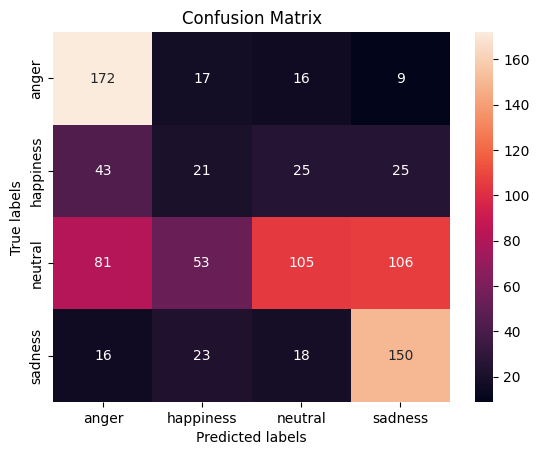


 Classification Report 
               precision    recall  f1-score   support

       anger       0.55      0.80      0.65       214
   happiness       0.18      0.18      0.18       114
     neutral       0.64      0.30      0.41       345
     sadness       0.52      0.72      0.60       207

    accuracy                           0.51       880
   macro avg       0.47      0.50      0.46       880
weighted avg       0.53      0.51      0.49       880
 

Train Epoch: 25 [0/3610 (0%)]	Loss: 1.102636

Train Epoch: 25 [640/3610 (18%)]	Loss: 1.145397

Train Epoch: 25 [1280/3610 (35%)]	Loss: 1.296452

Train Epoch: 25 [1920/3610 (53%)]	Loss: 1.166625

Train Epoch: 25 [2560/3610 (70%)]	Loss: 1.084637

Train Epoch: 25 [3200/3610 (88%)]	Loss: 1.115750


Train set: Average loss: 0.0176


Train Accuracy: 1910/3610 (53%)


Test set: Average loss: 0.0179, Accuracy: 455/880 (52%)



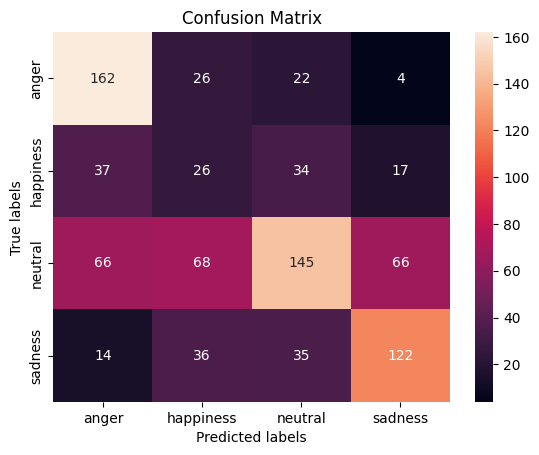


 Classification Report 
               precision    recall  f1-score   support

       anger       0.58      0.76      0.66       214
   happiness       0.17      0.23      0.19       114
     neutral       0.61      0.42      0.50       345
     sadness       0.58      0.59      0.59       207

    accuracy                           0.52       880
   macro avg       0.49      0.50      0.48       880
weighted avg       0.54      0.52      0.52       880
 

Train Epoch: 26 [0/3610 (0%)]	Loss: 1.246274

Train Epoch: 26 [640/3610 (18%)]	Loss: 1.115400

Train Epoch: 26 [1280/3610 (35%)]	Loss: 1.115198

Train Epoch: 26 [1920/3610 (53%)]	Loss: 1.116955

Train Epoch: 26 [2560/3610 (70%)]	Loss: 1.002560

Train Epoch: 26 [3200/3610 (88%)]	Loss: 1.157540


Train set: Average loss: 0.0175


Train Accuracy: 1920/3610 (53%)


Test set: Average loss: 0.0177, Accuracy: 466/880 (53%)



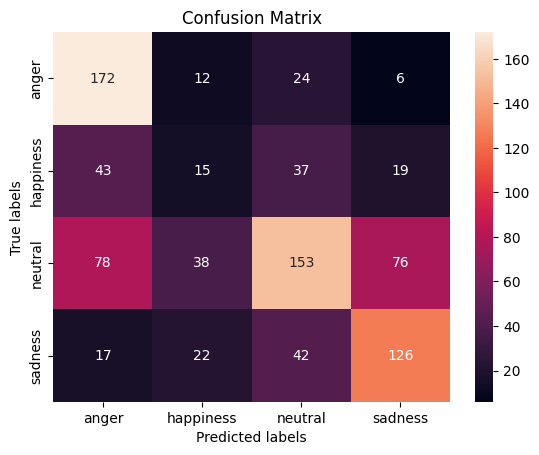


 Classification Report 
               precision    recall  f1-score   support

       anger       0.55      0.80      0.66       214
   happiness       0.17      0.13      0.15       114
     neutral       0.60      0.44      0.51       345
     sadness       0.56      0.61      0.58       207

    accuracy                           0.53       880
   macro avg       0.47      0.50      0.47       880
weighted avg       0.52      0.53      0.52       880
 

Train Epoch: 27 [0/3610 (0%)]	Loss: 1.021505

Train Epoch: 27 [640/3610 (18%)]	Loss: 1.058346

Train Epoch: 27 [1280/3610 (35%)]	Loss: 1.120705

Train Epoch: 27 [1920/3610 (53%)]	Loss: 1.192887

Train Epoch: 27 [2560/3610 (70%)]	Loss: 1.015086

Train Epoch: 27 [3200/3610 (88%)]	Loss: 1.026273


Train set: Average loss: 0.0173


Train Accuracy: 1933/3610 (54%)


Test set: Average loss: 0.0176, Accuracy: 470/880 (53%)



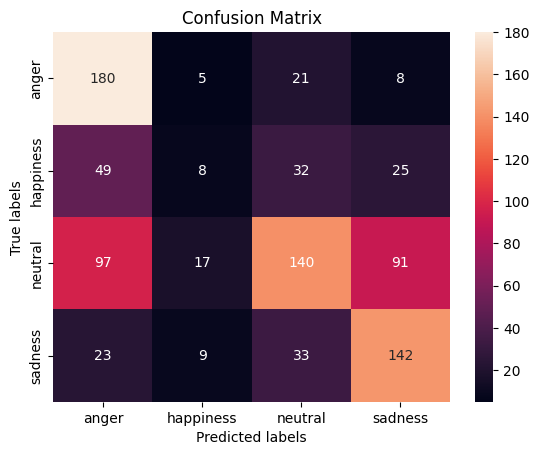


 Classification Report 
               precision    recall  f1-score   support

       anger       0.52      0.84      0.64       214
   happiness       0.21      0.07      0.10       114
     neutral       0.62      0.41      0.49       345
     sadness       0.53      0.69      0.60       207

    accuracy                           0.53       880
   macro avg       0.47      0.50      0.46       880
weighted avg       0.52      0.53      0.50       880
 

Train Epoch: 28 [0/3610 (0%)]	Loss: 1.199504

Train Epoch: 28 [640/3610 (18%)]	Loss: 1.099468

Train Epoch: 28 [1280/3610 (35%)]	Loss: 1.080529

Train Epoch: 28 [1920/3610 (53%)]	Loss: 1.147281

Train Epoch: 28 [2560/3610 (70%)]	Loss: 1.115877

Train Epoch: 28 [3200/3610 (88%)]	Loss: 1.007325


Train set: Average loss: 0.0173


Train Accuracy: 1931/3610 (53%)


Test set: Average loss: 0.0177, Accuracy: 459/880 (52%)



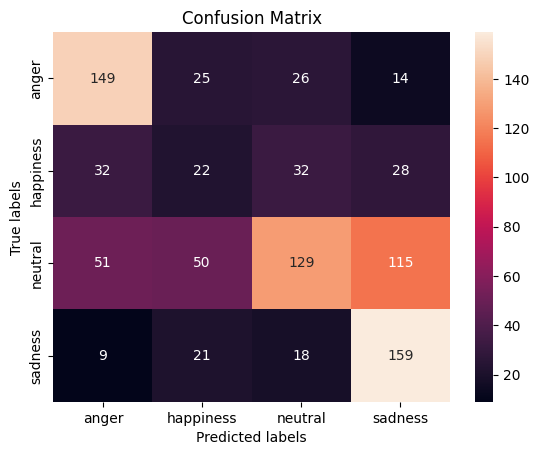


 Classification Report 
               precision    recall  f1-score   support

       anger       0.62      0.70      0.65       214
   happiness       0.19      0.19      0.19       114
     neutral       0.63      0.37      0.47       345
     sadness       0.50      0.77      0.61       207

    accuracy                           0.52       880
   macro avg       0.48      0.51      0.48       880
weighted avg       0.54      0.52      0.51       880
 

Train Epoch: 29 [0/3610 (0%)]	Loss: 1.051311

Train Epoch: 29 [640/3610 (18%)]	Loss: 1.129681

Train Epoch: 29 [1280/3610 (35%)]	Loss: 1.081957

Train Epoch: 29 [1920/3610 (53%)]	Loss: 1.082619

Train Epoch: 29 [2560/3610 (70%)]	Loss: 1.268213

Train Epoch: 29 [3200/3610 (88%)]	Loss: 1.072125


Train set: Average loss: 0.0172


Train Accuracy: 1973/3610 (55%)


Test set: Average loss: 0.0177, Accuracy: 458/880 (52%)



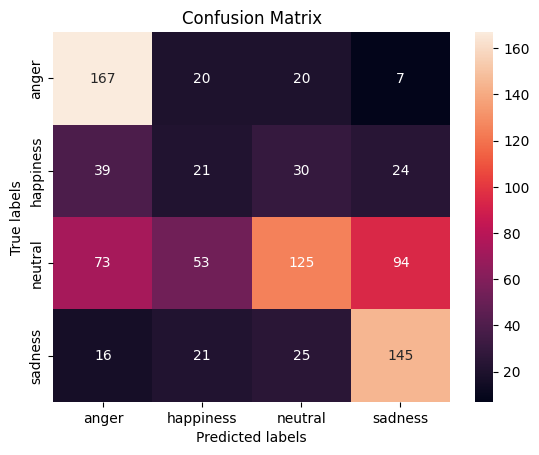


 Classification Report 
               precision    recall  f1-score   support

       anger       0.57      0.78      0.66       214
   happiness       0.18      0.18      0.18       114
     neutral       0.62      0.36      0.46       345
     sadness       0.54      0.70      0.61       207

    accuracy                           0.52       880
   macro avg       0.48      0.51      0.48       880
weighted avg       0.53      0.52      0.51       880
 

Train Epoch: 30 [0/3610 (0%)]	Loss: 1.034670

Train Epoch: 30 [640/3610 (18%)]	Loss: 1.112980

Train Epoch: 30 [1280/3610 (35%)]	Loss: 0.979365

Train Epoch: 30 [1920/3610 (53%)]	Loss: 1.138067

Train Epoch: 30 [2560/3610 (70%)]	Loss: 1.065693

Train Epoch: 30 [3200/3610 (88%)]	Loss: 1.116366


Train set: Average loss: 0.0173


Train Accuracy: 1959/3610 (54%)


Test set: Average loss: 0.0177, Accuracy: 460/880 (52%)



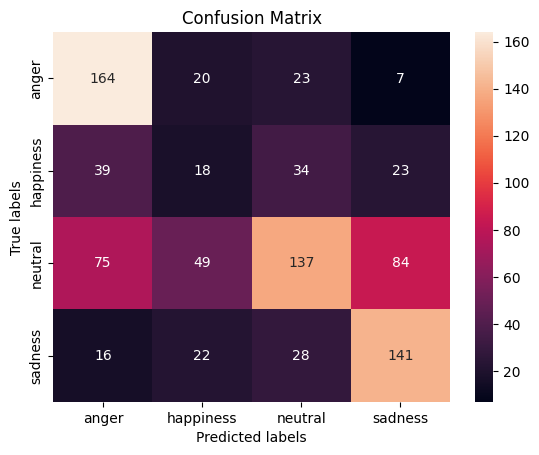


 Classification Report 
               precision    recall  f1-score   support

       anger       0.56      0.77      0.65       214
   happiness       0.17      0.16      0.16       114
     neutral       0.62      0.40      0.48       345
     sadness       0.55      0.68      0.61       207

    accuracy                           0.52       880
   macro avg       0.47      0.50      0.48       880
weighted avg       0.53      0.52      0.51       880
 

Train Epoch: 31 [0/3610 (0%)]	Loss: 1.081893

Train Epoch: 31 [640/3610 (18%)]	Loss: 1.217401

Train Epoch: 31 [1280/3610 (35%)]	Loss: 1.096805

Train Epoch: 31 [1920/3610 (53%)]	Loss: 1.064083

Train Epoch: 31 [2560/3610 (70%)]	Loss: 1.150729

Train Epoch: 31 [3200/3610 (88%)]	Loss: 1.090864


Train set: Average loss: 0.0172


Train Accuracy: 1948/3610 (54%)


Test set: Average loss: 0.0176, Accuracy: 465/880 (53%)



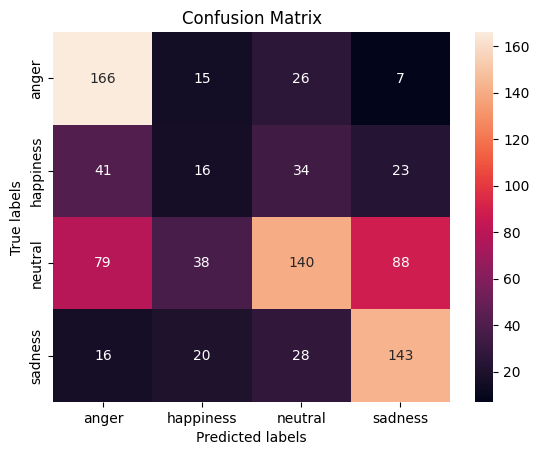


 Classification Report 
               precision    recall  f1-score   support

       anger       0.55      0.78      0.64       214
   happiness       0.18      0.14      0.16       114
     neutral       0.61      0.41      0.49       345
     sadness       0.55      0.69      0.61       207

    accuracy                           0.53       880
   macro avg       0.47      0.50      0.48       880
weighted avg       0.53      0.53      0.51       880
 

Train Epoch: 32 [0/3610 (0%)]	Loss: 1.150677

Train Epoch: 32 [640/3610 (18%)]	Loss: 1.127562

Train Epoch: 32 [1280/3610 (35%)]	Loss: 1.294194

Train Epoch: 32 [1920/3610 (53%)]	Loss: 0.972794

Train Epoch: 32 [2560/3610 (70%)]	Loss: 1.132439

Train Epoch: 32 [3200/3610 (88%)]	Loss: 1.124600


Train set: Average loss: 0.0170


Train Accuracy: 1974/3610 (55%)


Test set: Average loss: 0.0177, Accuracy: 454/880 (52%)



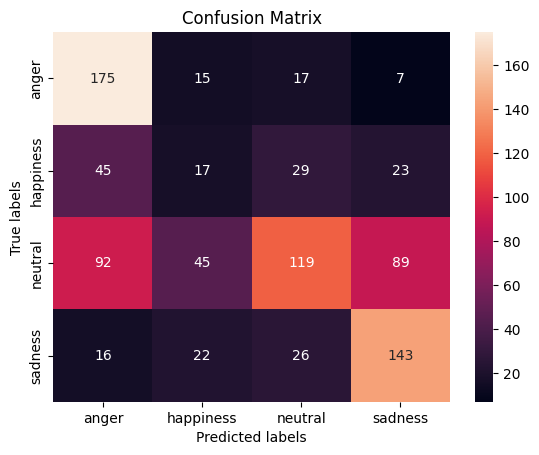


 Classification Report 
               precision    recall  f1-score   support

       anger       0.53      0.82      0.65       214
   happiness       0.17      0.15      0.16       114
     neutral       0.62      0.34      0.44       345
     sadness       0.55      0.69      0.61       207

    accuracy                           0.52       880
   macro avg       0.47      0.50      0.46       880
weighted avg       0.52      0.52      0.50       880
 

Train Epoch: 33 [0/3610 (0%)]	Loss: 1.016447

Train Epoch: 33 [640/3610 (18%)]	Loss: 1.033984

Train Epoch: 33 [1280/3610 (35%)]	Loss: 1.020019

Train Epoch: 33 [1920/3610 (53%)]	Loss: 1.036132

Train Epoch: 33 [2560/3610 (70%)]	Loss: 1.047547

Train Epoch: 33 [3200/3610 (88%)]	Loss: 1.057982


Train set: Average loss: 0.0169


Train Accuracy: 1959/3610 (54%)


Test set: Average loss: 0.0177, Accuracy: 468/880 (53%)



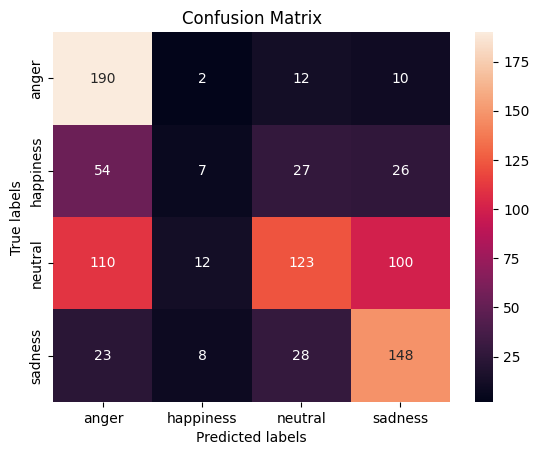


 Classification Report 
               precision    recall  f1-score   support

       anger       0.50      0.89      0.64       214
   happiness       0.24      0.06      0.10       114
     neutral       0.65      0.36      0.46       345
     sadness       0.52      0.71      0.60       207

    accuracy                           0.53       880
   macro avg       0.48      0.51      0.45       880
weighted avg       0.53      0.53      0.49       880
 

Train Epoch: 34 [0/3610 (0%)]	Loss: 1.030321

Train Epoch: 34 [640/3610 (18%)]	Loss: 1.081116

Train Epoch: 34 [1280/3610 (35%)]	Loss: 1.180155

Train Epoch: 34 [1920/3610 (53%)]	Loss: 1.055945

Train Epoch: 34 [2560/3610 (70%)]	Loss: 1.012402

Train Epoch: 34 [3200/3610 (88%)]	Loss: 1.112466


Train set: Average loss: 0.0170


Train Accuracy: 1992/3610 (55%)


Test set: Average loss: 0.0174, Accuracy: 478/880 (54%)



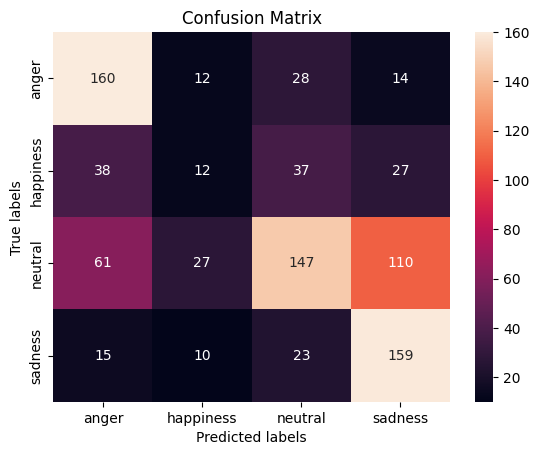


 Classification Report 
               precision    recall  f1-score   support

       anger       0.58      0.75      0.66       214
   happiness       0.20      0.11      0.14       114
     neutral       0.63      0.43      0.51       345
     sadness       0.51      0.77      0.62       207

    accuracy                           0.54       880
   macro avg       0.48      0.51      0.48       880
weighted avg       0.53      0.54      0.52       880
 

Train Epoch: 35 [0/3610 (0%)]	Loss: 1.030351

Train Epoch: 35 [640/3610 (18%)]	Loss: 1.070930

Train Epoch: 35 [1280/3610 (35%)]	Loss: 1.144811

Train Epoch: 35 [1920/3610 (53%)]	Loss: 1.093375

Train Epoch: 35 [2560/3610 (70%)]	Loss: 1.099343

Train Epoch: 35 [3200/3610 (88%)]	Loss: 1.109089


Train set: Average loss: 0.0170


Train Accuracy: 2002/3610 (55%)


Test set: Average loss: 0.0177, Accuracy: 452/880 (51%)



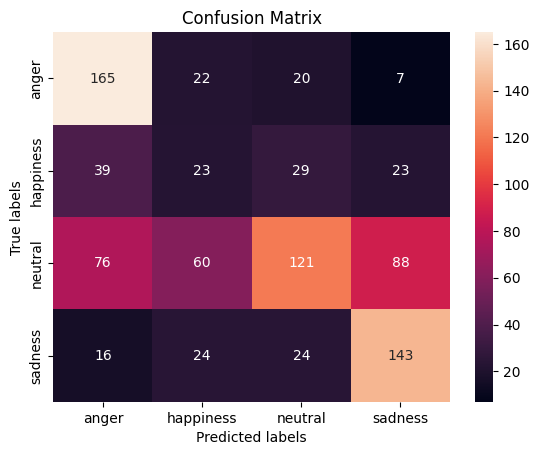


 Classification Report 
               precision    recall  f1-score   support

       anger       0.56      0.77      0.65       214
   happiness       0.18      0.20      0.19       114
     neutral       0.62      0.35      0.45       345
     sadness       0.55      0.69      0.61       207

    accuracy                           0.51       880
   macro avg       0.48      0.50      0.47       880
weighted avg       0.53      0.51      0.50       880
 

Train Epoch: 36 [0/3610 (0%)]	Loss: 1.183207

Train Epoch: 36 [640/3610 (18%)]	Loss: 0.990280

Train Epoch: 36 [1280/3610 (35%)]	Loss: 1.040335

Train Epoch: 36 [1920/3610 (53%)]	Loss: 0.915999

Train Epoch: 36 [2560/3610 (70%)]	Loss: 0.984204

Train Epoch: 36 [3200/3610 (88%)]	Loss: 1.170264


Train set: Average loss: 0.0169


Train Accuracy: 1960/3610 (54%)


Test set: Average loss: 0.0175, Accuracy: 471/880 (54%)



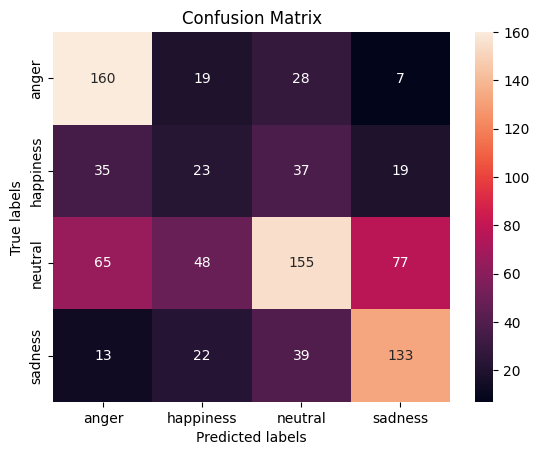


 Classification Report 
               precision    recall  f1-score   support

       anger       0.59      0.75      0.66       214
   happiness       0.21      0.20      0.20       114
     neutral       0.60      0.45      0.51       345
     sadness       0.56      0.64      0.60       207

    accuracy                           0.54       880
   macro avg       0.49      0.51      0.49       880
weighted avg       0.54      0.54      0.53       880
 

Train Epoch: 37 [0/3610 (0%)]	Loss: 1.087205

Train Epoch: 37 [640/3610 (18%)]	Loss: 1.116254

Train Epoch: 37 [1280/3610 (35%)]	Loss: 1.154550

Train Epoch: 37 [1920/3610 (53%)]	Loss: 1.197628

Train Epoch: 37 [2560/3610 (70%)]	Loss: 1.157859

Train Epoch: 37 [3200/3610 (88%)]	Loss: 1.020342


Train set: Average loss: 0.0169


Train Accuracy: 2001/3610 (55%)


Test set: Average loss: 0.0175, Accuracy: 470/880 (53%)



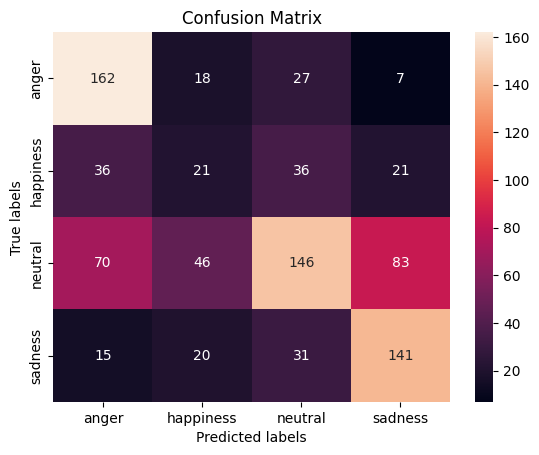


 Classification Report 
               precision    recall  f1-score   support

       anger       0.57      0.76      0.65       214
   happiness       0.20      0.18      0.19       114
     neutral       0.61      0.42      0.50       345
     sadness       0.56      0.68      0.61       207

    accuracy                           0.53       880
   macro avg       0.49      0.51      0.49       880
weighted avg       0.54      0.53      0.52       880
 

Train Epoch: 38 [0/3610 (0%)]	Loss: 0.951155

Train Epoch: 38 [640/3610 (18%)]	Loss: 1.060263

Train Epoch: 38 [1280/3610 (35%)]	Loss: 1.129799

Train Epoch: 38 [1920/3610 (53%)]	Loss: 1.207063

Train Epoch: 38 [2560/3610 (70%)]	Loss: 1.083153

Train Epoch: 38 [3200/3610 (88%)]	Loss: 1.015663


Train set: Average loss: 0.0169


Train Accuracy: 2004/3610 (56%)


Test set: Average loss: 0.0173, Accuracy: 471/880 (54%)



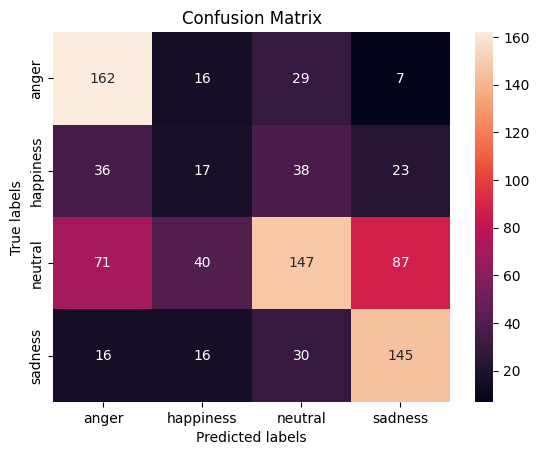


 Classification Report 
               precision    recall  f1-score   support

       anger       0.57      0.76      0.65       214
   happiness       0.19      0.15      0.17       114
     neutral       0.60      0.43      0.50       345
     sadness       0.55      0.70      0.62       207

    accuracy                           0.54       880
   macro avg       0.48      0.51      0.48       880
weighted avg       0.53      0.54      0.52       880
 

Train Epoch: 39 [0/3610 (0%)]	Loss: 1.279807

Train Epoch: 39 [640/3610 (18%)]	Loss: 1.068147

Train Epoch: 39 [1280/3610 (35%)]	Loss: 1.102758

Train Epoch: 39 [1920/3610 (53%)]	Loss: 0.988322

Train Epoch: 39 [2560/3610 (70%)]	Loss: 0.946969

Train Epoch: 39 [3200/3610 (88%)]	Loss: 1.206909


Train set: Average loss: 0.0167


Train Accuracy: 2001/3610 (55%)


Test set: Average loss: 0.0178, Accuracy: 451/880 (51%)



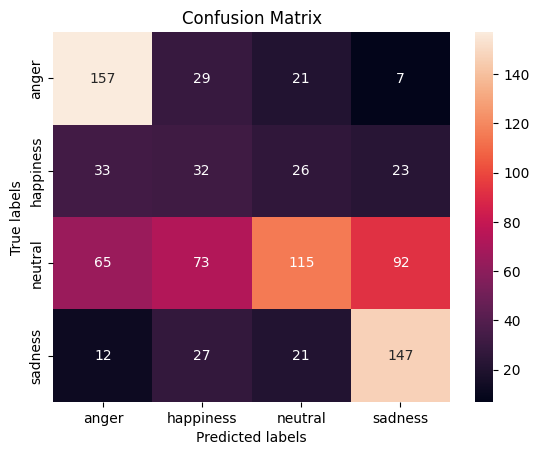


 Classification Report 
               precision    recall  f1-score   support

       anger       0.59      0.73      0.65       214
   happiness       0.20      0.28      0.23       114
     neutral       0.63      0.33      0.44       345
     sadness       0.55      0.71      0.62       207

    accuracy                           0.51       880
   macro avg       0.49      0.51      0.48       880
weighted avg       0.54      0.51      0.50       880
 

Train Epoch: 40 [0/3610 (0%)]	Loss: 1.082363

Train Epoch: 40 [640/3610 (18%)]	Loss: 1.028191

Train Epoch: 40 [1280/3610 (35%)]	Loss: 0.957056

Train Epoch: 40 [1920/3610 (53%)]	Loss: 1.028529

Train Epoch: 40 [2560/3610 (70%)]	Loss: 0.973535

Train Epoch: 40 [3200/3610 (88%)]	Loss: 1.129154


Train set: Average loss: 0.0168


Train Accuracy: 1961/3610 (54%)


Test set: Average loss: 0.0178, Accuracy: 462/880 (52%)



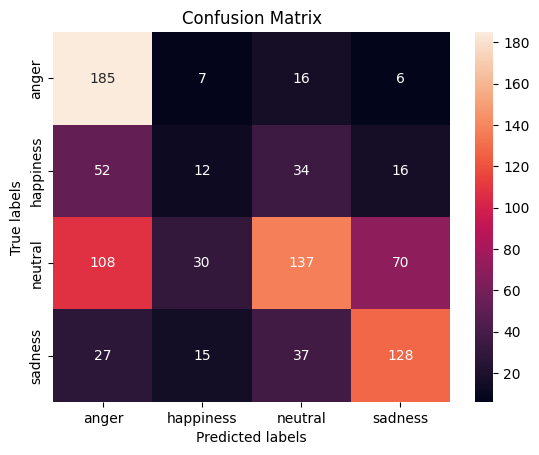


 Classification Report 
               precision    recall  f1-score   support

       anger       0.50      0.86      0.63       214
   happiness       0.19      0.11      0.13       114
     neutral       0.61      0.40      0.48       345
     sadness       0.58      0.62      0.60       207

    accuracy                           0.53       880
   macro avg       0.47      0.50      0.46       880
weighted avg       0.52      0.53      0.50       880
 

Train Epoch: 41 [0/3610 (0%)]	Loss: 0.997061

Train Epoch: 41 [640/3610 (18%)]	Loss: 1.210995

Train Epoch: 41 [1280/3610 (35%)]	Loss: 1.123762

Train Epoch: 41 [1920/3610 (53%)]	Loss: 1.060827

Train Epoch: 41 [2560/3610 (70%)]	Loss: 1.132462

Train Epoch: 41 [3200/3610 (88%)]	Loss: 1.058799


Train set: Average loss: 0.0167


Train Accuracy: 2025/3610 (56%)


Test set: Average loss: 0.0178, Accuracy: 449/880 (51%)



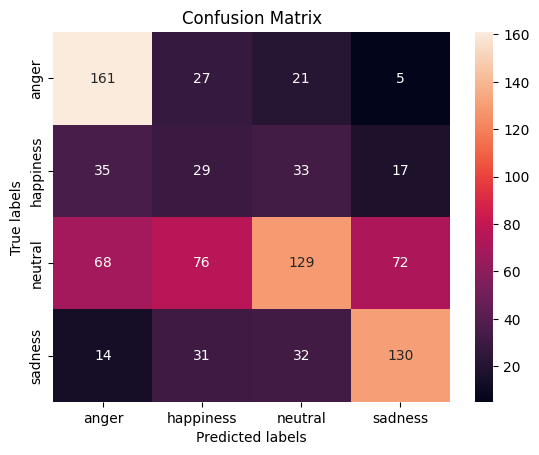


 Classification Report 
               precision    recall  f1-score   support

       anger       0.58      0.75      0.65       214
   happiness       0.18      0.25      0.21       114
     neutral       0.60      0.37      0.46       345
     sadness       0.58      0.63      0.60       207

    accuracy                           0.51       880
   macro avg       0.48      0.50      0.48       880
weighted avg       0.54      0.51      0.51       880
 

Train Epoch: 42 [0/3610 (0%)]	Loss: 1.001256

Train Epoch: 42 [640/3610 (18%)]	Loss: 1.018015

Train Epoch: 42 [1280/3610 (35%)]	Loss: 1.034077

Train Epoch: 42 [1920/3610 (53%)]	Loss: 0.993140

Train Epoch: 42 [2560/3610 (70%)]	Loss: 1.079744

Train Epoch: 42 [3200/3610 (88%)]	Loss: 1.014016


Train set: Average loss: 0.0165


Train Accuracy: 2004/3610 (56%)


Test set: Average loss: 0.0175, Accuracy: 462/880 (52%)



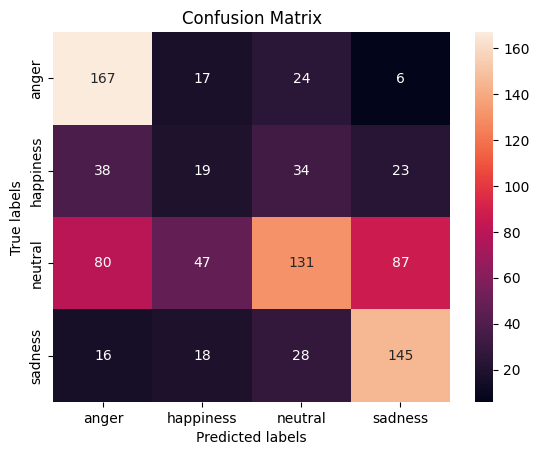


 Classification Report 
               precision    recall  f1-score   support

       anger       0.55      0.78      0.65       214
   happiness       0.19      0.17      0.18       114
     neutral       0.60      0.38      0.47       345
     sadness       0.56      0.70      0.62       207

    accuracy                           0.53       880
   macro avg       0.48      0.51      0.48       880
weighted avg       0.53      0.53      0.51       880
 

Train Epoch: 43 [0/3610 (0%)]	Loss: 1.035163

Train Epoch: 43 [640/3610 (18%)]	Loss: 1.121502

Train Epoch: 43 [1280/3610 (35%)]	Loss: 1.047658

Train Epoch: 43 [1920/3610 (53%)]	Loss: 1.147451

Train Epoch: 43 [2560/3610 (70%)]	Loss: 0.910972

Train Epoch: 43 [3200/3610 (88%)]	Loss: 0.981901


Train set: Average loss: 0.0166


Train Accuracy: 2006/3610 (56%)


Test set: Average loss: 0.0181, Accuracy: 418/880 (48%)



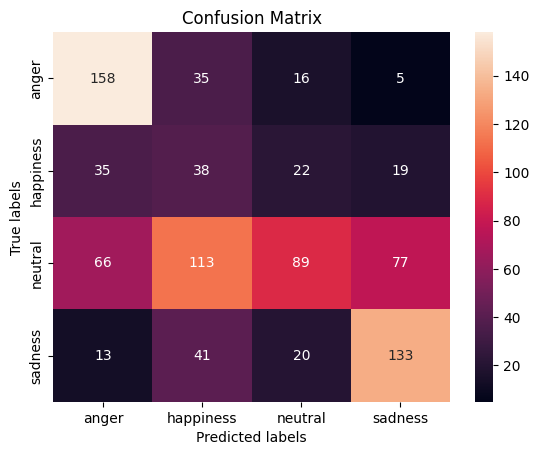


 Classification Report 
               precision    recall  f1-score   support

       anger       0.58      0.74      0.65       214
   happiness       0.17      0.33      0.22       114
     neutral       0.61      0.26      0.36       345
     sadness       0.57      0.64      0.60       207

    accuracy                           0.48       880
   macro avg       0.48      0.49      0.46       880
weighted avg       0.53      0.47      0.47       880
 

Train Epoch: 44 [0/3610 (0%)]	Loss: 1.226158

Train Epoch: 44 [640/3610 (18%)]	Loss: 1.040398

Train Epoch: 44 [1280/3610 (35%)]	Loss: 1.117124

Train Epoch: 44 [1920/3610 (53%)]	Loss: 1.120109

Train Epoch: 44 [2560/3610 (70%)]	Loss: 1.115394

Train Epoch: 44 [3200/3610 (88%)]	Loss: 1.100222


Train set: Average loss: 0.0166


Train Accuracy: 2041/3610 (57%)


Test set: Average loss: 0.0172, Accuracy: 488/880 (55%)



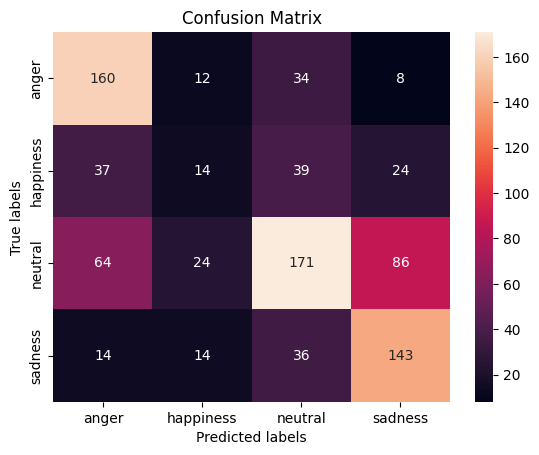


 Classification Report 
               precision    recall  f1-score   support

       anger       0.58      0.75      0.65       214
   happiness       0.22      0.12      0.16       114
     neutral       0.61      0.50      0.55       345
     sadness       0.55      0.69      0.61       207

    accuracy                           0.55       880
   macro avg       0.49      0.51      0.49       880
weighted avg       0.54      0.55      0.54       880
 

Train Epoch: 45 [0/3610 (0%)]	Loss: 0.981086

Train Epoch: 45 [640/3610 (18%)]	Loss: 1.149077

Train Epoch: 45 [1280/3610 (35%)]	Loss: 0.964642

Train Epoch: 45 [1920/3610 (53%)]	Loss: 1.244896

Train Epoch: 45 [2560/3610 (70%)]	Loss: 0.956903

Train Epoch: 45 [3200/3610 (88%)]	Loss: 1.059562


Train set: Average loss: 0.0166


Train Accuracy: 2012/3610 (56%)


Test set: Average loss: 0.0175, Accuracy: 467/880 (53%)



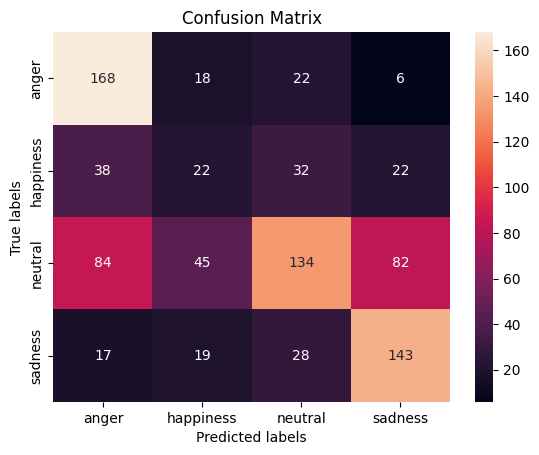


 Classification Report 
               precision    recall  f1-score   support

       anger       0.55      0.79      0.64       214
   happiness       0.21      0.19      0.20       114
     neutral       0.62      0.39      0.48       345
     sadness       0.57      0.69      0.62       207

    accuracy                           0.53       880
   macro avg       0.49      0.51      0.49       880
weighted avg       0.54      0.53      0.52       880
 

Train Epoch: 46 [0/3610 (0%)]	Loss: 1.164136

Train Epoch: 46 [640/3610 (18%)]	Loss: 1.032480

Train Epoch: 46 [1280/3610 (35%)]	Loss: 1.084576

Train Epoch: 46 [1920/3610 (53%)]	Loss: 1.030391

Train Epoch: 46 [2560/3610 (70%)]	Loss: 1.110309

Train Epoch: 46 [3200/3610 (88%)]	Loss: 1.088833


Train set: Average loss: 0.0166


Train Accuracy: 2013/3610 (56%)


Test set: Average loss: 0.0176, Accuracy: 455/880 (52%)



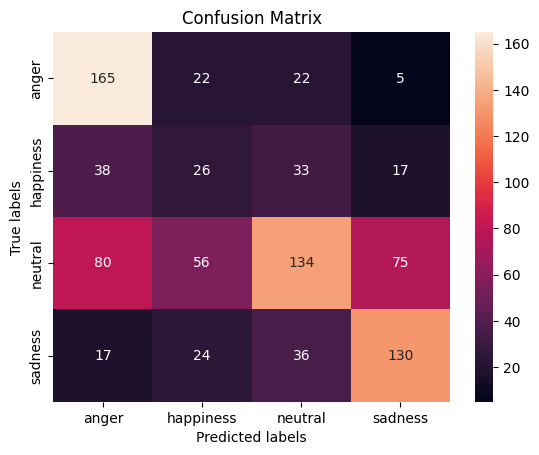


 Classification Report 
               precision    recall  f1-score   support

       anger       0.55      0.77      0.64       214
   happiness       0.20      0.23      0.21       114
     neutral       0.60      0.39      0.47       345
     sadness       0.57      0.63      0.60       207

    accuracy                           0.52       880
   macro avg       0.48      0.50      0.48       880
weighted avg       0.53      0.52      0.51       880
 

Train Epoch: 47 [0/3610 (0%)]	Loss: 1.038351

Train Epoch: 47 [640/3610 (18%)]	Loss: 1.074983

Train Epoch: 47 [1280/3610 (35%)]	Loss: 0.948808

Train Epoch: 47 [1920/3610 (53%)]	Loss: 1.000936

Train Epoch: 47 [2560/3610 (70%)]	Loss: 1.022287

Train Epoch: 47 [3200/3610 (88%)]	Loss: 1.039712


Train set: Average loss: 0.0165


Train Accuracy: 2012/3610 (56%)


Test set: Average loss: 0.0177, Accuracy: 458/880 (52%)



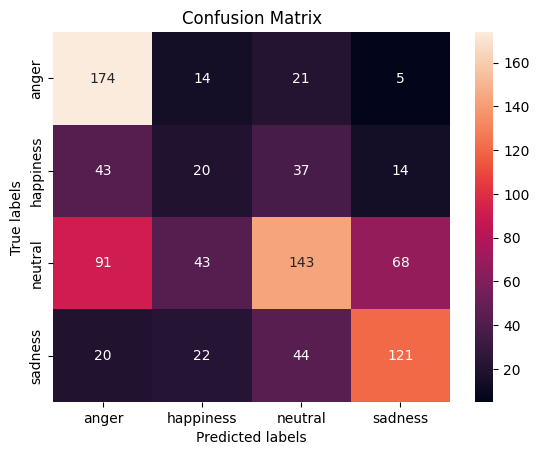


 Classification Report 
               precision    recall  f1-score   support

       anger       0.53      0.81      0.64       214
   happiness       0.20      0.18      0.19       114
     neutral       0.58      0.41      0.48       345
     sadness       0.58      0.58      0.58       207

    accuracy                           0.52       880
   macro avg       0.47      0.50      0.47       880
weighted avg       0.52      0.52      0.51       880
 

Train Epoch: 48 [0/3610 (0%)]	Loss: 1.135036

Train Epoch: 48 [640/3610 (18%)]	Loss: 1.116023

Train Epoch: 48 [1280/3610 (35%)]	Loss: 1.007709

Train Epoch: 48 [1920/3610 (53%)]	Loss: 0.997618

Train Epoch: 48 [2560/3610 (70%)]	Loss: 0.926456

Train Epoch: 48 [3200/3610 (88%)]	Loss: 1.062509


Train set: Average loss: 0.0163


Train Accuracy: 2044/3610 (57%)


Test set: Average loss: 0.0175, Accuracy: 475/880 (54%)



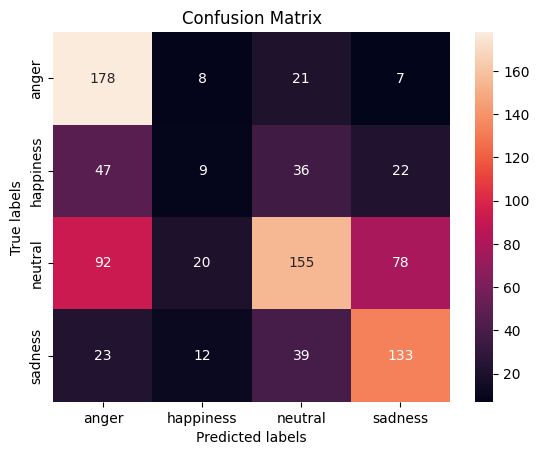


 Classification Report 
               precision    recall  f1-score   support

       anger       0.52      0.83      0.64       214
   happiness       0.18      0.08      0.11       114
     neutral       0.62      0.45      0.52       345
     sadness       0.55      0.64      0.60       207

    accuracy                           0.54       880
   macro avg       0.47      0.50      0.47       880
weighted avg       0.52      0.54      0.51       880
 

Train Epoch: 49 [0/3610 (0%)]	Loss: 0.978984

Train Epoch: 49 [640/3610 (18%)]	Loss: 1.169021

Train Epoch: 49 [1280/3610 (35%)]	Loss: 0.974322

Train Epoch: 49 [1920/3610 (53%)]	Loss: 1.059664

Train Epoch: 49 [2560/3610 (70%)]	Loss: 0.935018

Train Epoch: 49 [3200/3610 (88%)]	Loss: 1.056820


Train set: Average loss: 0.0164


Train Accuracy: 2049/3610 (57%)


Test set: Average loss: 0.0174, Accuracy: 466/880 (53%)



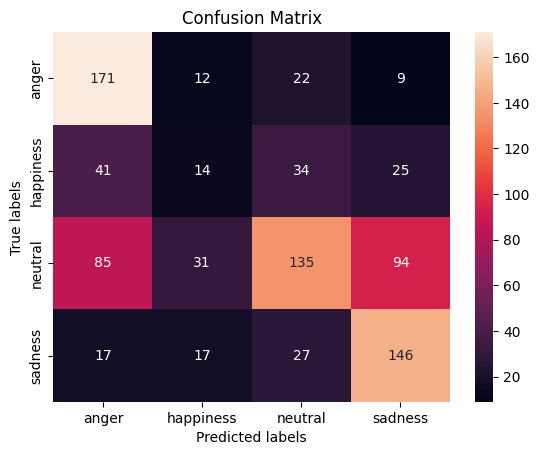


 Classification Report 
               precision    recall  f1-score   support

       anger       0.54      0.80      0.65       214
   happiness       0.19      0.12      0.15       114
     neutral       0.62      0.39      0.48       345
     sadness       0.53      0.71      0.61       207

    accuracy                           0.53       880
   macro avg       0.47      0.50      0.47       880
weighted avg       0.53      0.53      0.51       880
 

Train Epoch: 50 [0/3610 (0%)]	Loss: 0.888635

Train Epoch: 50 [640/3610 (18%)]	Loss: 0.965671

Train Epoch: 50 [1280/3610 (35%)]	Loss: 0.965085

Train Epoch: 50 [1920/3610 (53%)]	Loss: 1.049583

Train Epoch: 50 [2560/3610 (70%)]	Loss: 1.006826

Train Epoch: 50 [3200/3610 (88%)]	Loss: 1.133557


Train set: Average loss: 0.0164


Train Accuracy: 2062/3610 (57%)


Test set: Average loss: 0.0183, Accuracy: 396/880 (45%)



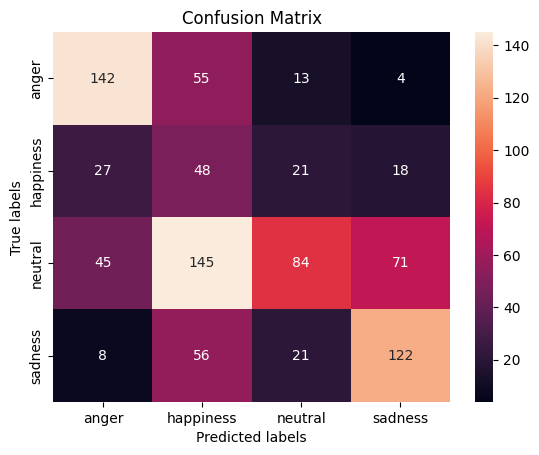


 Classification Report 
               precision    recall  f1-score   support

       anger       0.64      0.66      0.65       214
   happiness       0.16      0.42      0.23       114
     neutral       0.60      0.24      0.35       345
     sadness       0.57      0.59      0.58       207

    accuracy                           0.45       880
   macro avg       0.49      0.48      0.45       880
weighted avg       0.55      0.45      0.46       880
 



In [30]:
history = []
n_epoch = 51
for epoch in range(1, n_epoch):
#     exp_lr_scheduler.step(epoch)
    
    train_loss, train_acc = train(epoch, model)
    
    test_loss, test_acc = test(model)
    
#     plateau_scheduler.step(test_loss)
    
    history.append([train_loss, train_acc, test_loss, test_acc])

In [31]:
history_df = pd.DataFrame(history, columns=["train_loss", "train_acc", "test_loss", "test_acc"])

In [32]:
history_df["epoch"] = [x for x in range(1, n_epoch)]

In [33]:
history_df

train_loss  train_acc  test_loss  test_acc  epoch
0     0.021781         27   0.021549        42      1
1     0.021242         37   0.021044        47      2
2     0.020876         41   0.020879        44      3
3     0.020501         42   0.020346        46      4
4     0.020099         44   0.020083        45      5
5     0.019702         46   0.019475        50      6
6     0.019462         47   0.019217        49      7
7     0.019129         49   0.019263        46      8
8     0.019033         49   0.019296        46      9
9     0.018929         47   0.018929        48     10
10    0.018712         48   0.018520        51     11
11    0.018508         50   0.018506        50     12
12    0.018487         50   0.018319        51     13
13    0.018333         50   0.018516        49     14
14    0.018219         50   0.018318        50     15
15    0.018158         50   0.018008        52     16
16    0.018035         51   0.018245        50     17
17    0.018015         52   0.018190        50     18
18    0.017832         51   0.018084        50     19
19    0.017698         52   0.018136        49     20
20    0.017731         53   0.018300        47     21
21    0.017677         51   0.018061        49     22
22    0.017534         53   0.017738        52     23
23    0.017604         53   0.017969        50     24
24    0.017583         52   0.017929        51     25
25    0.017467         53   0.017713        52     26
26    0.017305         53   0.017645        53     27
27    0.017320         53   0.017697        52     28
28    0.017203         54   0.017681        52     29
29    0.017322         54   0.017669        52     30
30    0.017220         53   0.017585        52     31
31    0.017005         54   0.017737        51     32
32    0.016922         54   0.017657        53     33
33    0.016956         55   0.017402        54     34
34    0.016998         55   0.017713        51     35
35    0.016946         54   0.017484        53     36
36    0.016877         55   0.017497        53     37
37    0.016857         55   0.017341        53     38
38    0.016742         55   0.017758        51     39
39    0.016778         54   0.017833        52     40
40    0.016733         56   0.017769        51     41
41    0.016533         55   0.017544        52     42
42    0.016637         55   0.018095        47     43
43    0.016593         56   0.017156        55     44
44    0.016585         55   0.017519        53     45
45    0.016608         55   0.017649        51     46
46    0.016488         55   0.017715        52     47
47    0.016312         56   0.017457        53     48
48    0.016427         56   0.017445        52     49
49    0.016351         57   0.018301        45     50

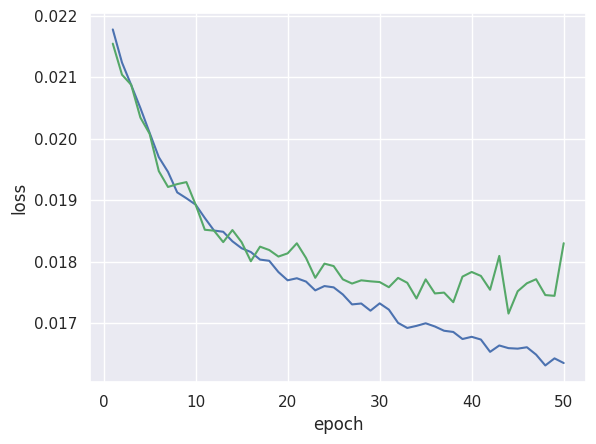

In [34]:
sns.set()
sns.lineplot(x='epoch', y='train_loss', data=history_df, color='b')
# plt.xticks(history_df.epoch)
sns.lineplot(x='epoch', y='test_loss', data=history_df, color='g')
plt.ylabel("loss")
plt.show()

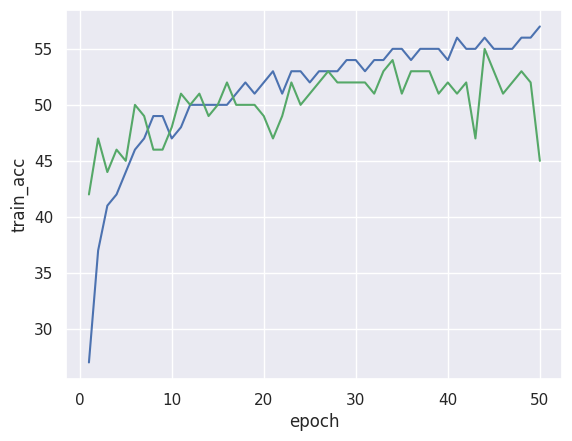

In [35]:
sns.set()
sns.lineplot(x='epoch', y='train_acc', data=history_df, color='b')
# plt.xticks(history_df.epoch)
sns.lineplot(x='epoch', y='test_acc', data=history_df, color='g')
plt.show()

In [36]:
torch.save(model, model_save_path + '/ResNet152_Freeze_Weights.pth')

In [37]:
model = torch.load(model_save_path + '/ResNet152_Freeze_Weights.pth')

In [38]:
ct = 0
for child in model.children():
    ct += 1
    if ct > 7:
        print("child", ct, "was not frozen")
        for param in child.parameters():
            param.requires_grad = True
    else:
        print("child", ct, "was frozen")

child 1 was frozen
child 2 was frozen
child 3 was frozen
child 4 was frozen
child 5 was frozen
child 6 was frozen
child 7 was frozen
child 8 was not frozen
child 9 was not frozen
child 10 was not frozen


In [39]:
# for param in model.parameters():
#     param.requires_grad = True

In [40]:
# optimizer = optim.RMSprop(model.parameters(), lr=0.0003)
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005)
model = model.to(device)

In [41]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

23,918,636 total parameters.
15,375,340 training parameters.


In [42]:
model = model.to(device)

Train Epoch: 1 [0/3610 (0%)]	Loss: 1.069693

Train Epoch: 1 [640/3610 (18%)]	Loss: 1.153079

Train Epoch: 1 [1280/3610 (35%)]	Loss: 0.961663

Train Epoch: 1 [1920/3610 (53%)]	Loss: 1.014859

Train Epoch: 1 [2560/3610 (70%)]	Loss: 1.058276

Train Epoch: 1 [3200/3610 (88%)]	Loss: 0.931107


Train set: Average loss: 0.0164


Train Accuracy: 1941/3610 (54%)


Test set: Average loss: 0.0177, Accuracy: 448/880 (51%)



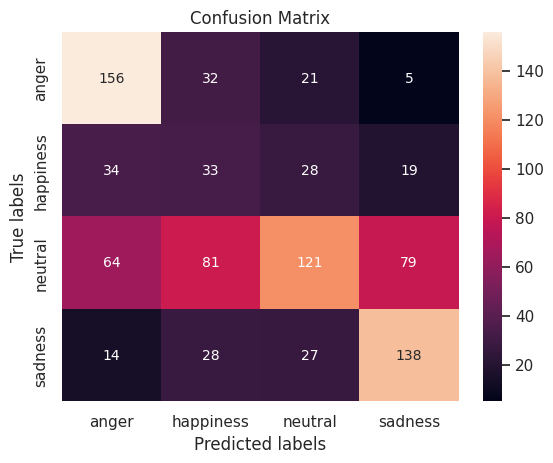


 Classification Report 
               precision    recall  f1-score   support

       anger       0.58      0.73      0.65       214
   happiness       0.19      0.29      0.23       114
     neutral       0.61      0.35      0.45       345
     sadness       0.57      0.67      0.62       207

    accuracy                           0.51       880
   macro avg       0.49      0.51      0.48       880
weighted avg       0.54      0.51      0.51       880
 

Train Epoch: 2 [0/3610 (0%)]	Loss: 1.141893

Train Epoch: 2 [640/3610 (18%)]	Loss: 1.030267

Train Epoch: 2 [1280/3610 (35%)]	Loss: 1.102040

Train Epoch: 2 [1920/3610 (53%)]	Loss: 1.054194

Train Epoch: 2 [2560/3610 (70%)]	Loss: 0.952623

Train Epoch: 2 [3200/3610 (88%)]	Loss: 1.003106


Train set: Average loss: 0.0161


Train Accuracy: 2071/3610 (57%)


Test set: Average loss: 0.0175, Accuracy: 464/880 (53%)



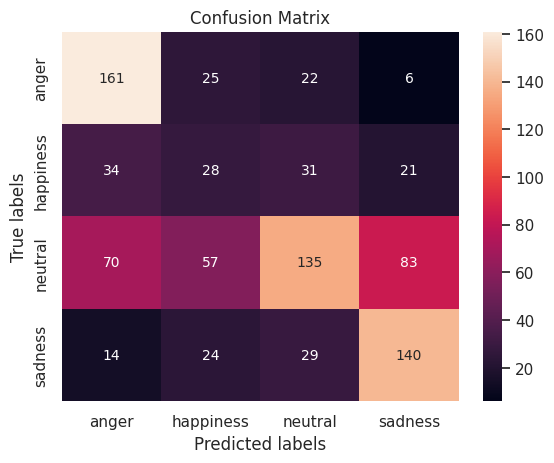


 Classification Report 
               precision    recall  f1-score   support

       anger       0.58      0.75      0.65       214
   happiness       0.21      0.25      0.23       114
     neutral       0.62      0.39      0.48       345
     sadness       0.56      0.68      0.61       207

    accuracy                           0.53       880
   macro avg       0.49      0.52      0.49       880
weighted avg       0.54      0.53      0.52       880
 

Train Epoch: 3 [0/3610 (0%)]	Loss: 1.018478

Train Epoch: 3 [640/3610 (18%)]	Loss: 0.990861

Train Epoch: 3 [1280/3610 (35%)]	Loss: 0.905836

Train Epoch: 3 [1920/3610 (53%)]	Loss: 0.934266

Train Epoch: 3 [2560/3610 (70%)]	Loss: 1.072387

Train Epoch: 3 [3200/3610 (88%)]	Loss: 0.982534


Train set: Average loss: 0.0161


Train Accuracy: 2093/3610 (58%)


Test set: Average loss: 0.0174, Accuracy: 469/880 (53%)



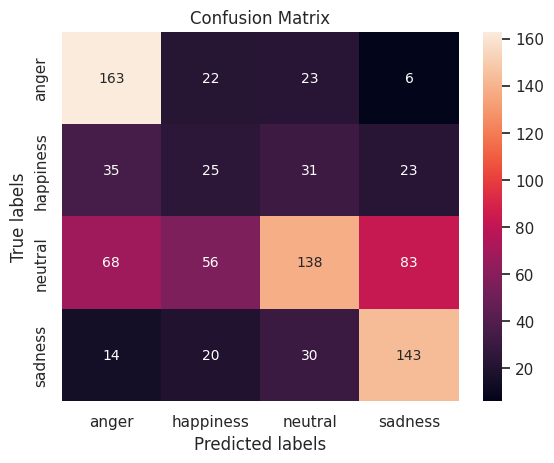


 Classification Report 
               precision    recall  f1-score   support

       anger       0.58      0.76      0.66       214
   happiness       0.20      0.22      0.21       114
     neutral       0.62      0.40      0.49       345
     sadness       0.56      0.69      0.62       207

    accuracy                           0.53       880
   macro avg       0.49      0.52      0.49       880
weighted avg       0.54      0.53      0.52       880
 

Train Epoch: 4 [0/3610 (0%)]	Loss: 1.160632

Train Epoch: 4 [640/3610 (18%)]	Loss: 1.166072

Train Epoch: 4 [1280/3610 (35%)]	Loss: 1.026010

Train Epoch: 4 [1920/3610 (53%)]	Loss: 0.943007

Train Epoch: 4 [2560/3610 (70%)]	Loss: 1.119623

Train Epoch: 4 [3200/3610 (88%)]	Loss: 1.023944


Train set: Average loss: 0.0159


Train Accuracy: 2117/3610 (59%)


Test set: Average loss: 0.0174, Accuracy: 467/880 (53%)



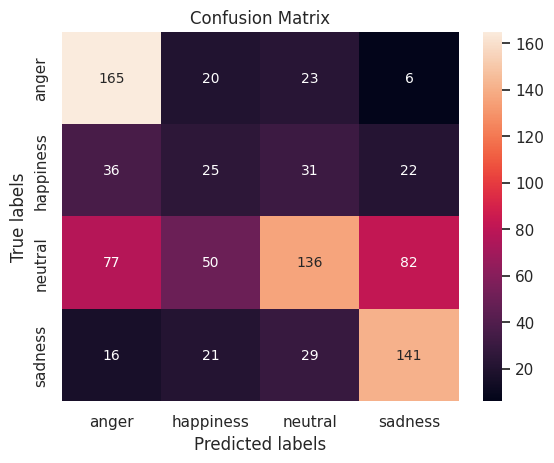


 Classification Report 
               precision    recall  f1-score   support

       anger       0.56      0.77      0.65       214
   happiness       0.22      0.22      0.22       114
     neutral       0.62      0.39      0.48       345
     sadness       0.56      0.68      0.62       207

    accuracy                           0.53       880
   macro avg       0.49      0.52      0.49       880
weighted avg       0.54      0.53      0.52       880
 

Train Epoch: 5 [0/3610 (0%)]	Loss: 0.869657

Train Epoch: 5 [640/3610 (18%)]	Loss: 1.054747

Train Epoch: 5 [1280/3610 (35%)]	Loss: 1.145056

Train Epoch: 5 [1920/3610 (53%)]	Loss: 1.007158

Train Epoch: 5 [2560/3610 (70%)]	Loss: 1.101048

Train Epoch: 5 [3200/3610 (88%)]	Loss: 0.866694


Train set: Average loss: 0.0156


Train Accuracy: 2138/3610 (59%)


Test set: Average loss: 0.0173, Accuracy: 468/880 (53%)



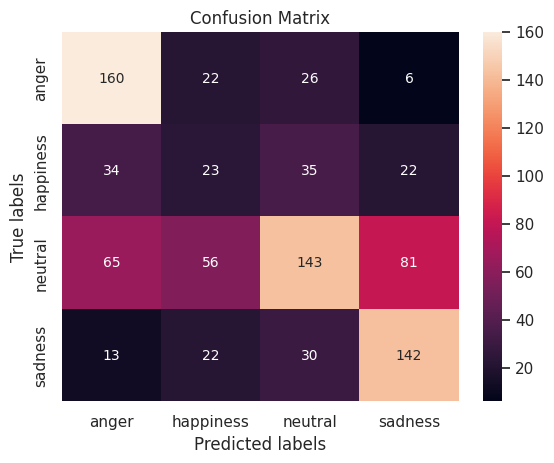


 Classification Report 
               precision    recall  f1-score   support

       anger       0.59      0.75      0.66       214
   happiness       0.19      0.20      0.19       114
     neutral       0.61      0.41      0.49       345
     sadness       0.57      0.69      0.62       207

    accuracy                           0.53       880
   macro avg       0.49      0.51      0.49       880
weighted avg       0.54      0.53      0.52       880
 

Train Epoch: 6 [0/3610 (0%)]	Loss: 1.137137

Train Epoch: 6 [640/3610 (18%)]	Loss: 0.976180

Train Epoch: 6 [1280/3610 (35%)]	Loss: 0.922281

Train Epoch: 6 [1920/3610 (53%)]	Loss: 1.042544

Train Epoch: 6 [2560/3610 (70%)]	Loss: 1.046221

Train Epoch: 6 [3200/3610 (88%)]	Loss: 0.931131


Train set: Average loss: 0.0156


Train Accuracy: 2147/3610 (59%)


Test set: Average loss: 0.0173, Accuracy: 475/880 (54%)



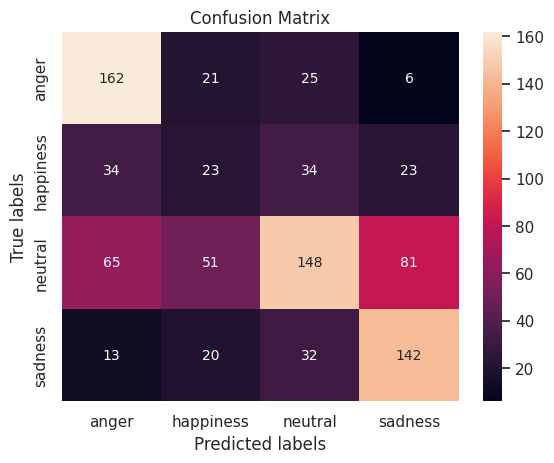


 Classification Report 
               precision    recall  f1-score   support

       anger       0.59      0.76      0.66       214
   happiness       0.20      0.20      0.20       114
     neutral       0.62      0.43      0.51       345
     sadness       0.56      0.69      0.62       207

    accuracy                           0.54       880
   macro avg       0.49      0.52      0.50       880
weighted avg       0.55      0.54      0.53       880
 

Train Epoch: 7 [0/3610 (0%)]	Loss: 0.859181

Train Epoch: 7 [640/3610 (18%)]	Loss: 0.953886

Train Epoch: 7 [1280/3610 (35%)]	Loss: 0.906609

Train Epoch: 7 [1920/3610 (53%)]	Loss: 0.915325

Train Epoch: 7 [2560/3610 (70%)]	Loss: 0.904596

Train Epoch: 7 [3200/3610 (88%)]	Loss: 1.027937


Train set: Average loss: 0.0154


Train Accuracy: 2169/3610 (60%)


Test set: Average loss: 0.0173, Accuracy: 468/880 (53%)



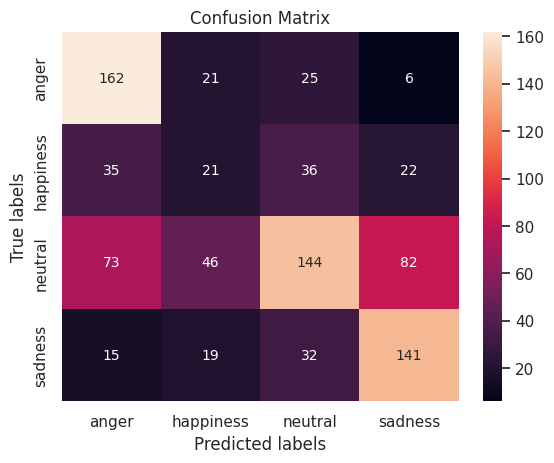


 Classification Report 
               precision    recall  f1-score   support

       anger       0.57      0.76      0.65       214
   happiness       0.20      0.18      0.19       114
     neutral       0.61      0.42      0.49       345
     sadness       0.56      0.68      0.62       207

    accuracy                           0.53       880
   macro avg       0.48      0.51      0.49       880
weighted avg       0.53      0.53      0.52       880
 

Train Epoch: 8 [0/3610 (0%)]	Loss: 0.979790

Train Epoch: 8 [640/3610 (18%)]	Loss: 0.913434

Train Epoch: 8 [1280/3610 (35%)]	Loss: 1.051589

Train Epoch: 8 [1920/3610 (53%)]	Loss: 0.922165

Train Epoch: 8 [2560/3610 (70%)]	Loss: 1.068335

Train Epoch: 8 [3200/3610 (88%)]	Loss: 0.868449


Train set: Average loss: 0.0153


Train Accuracy: 2202/3610 (61%)


Test set: Average loss: 0.0172, Accuracy: 474/880 (54%)



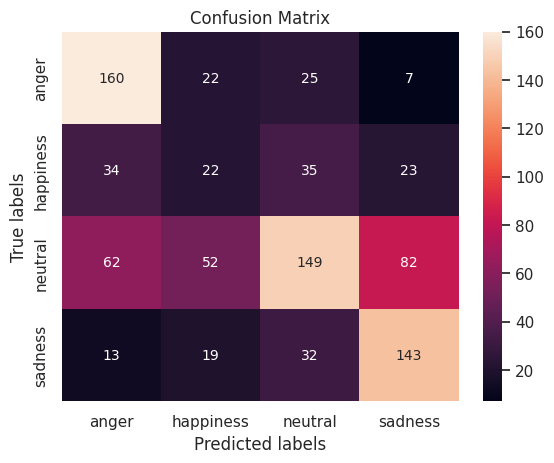


 Classification Report 
               precision    recall  f1-score   support

       anger       0.59      0.75      0.66       214
   happiness       0.19      0.19      0.19       114
     neutral       0.62      0.43      0.51       345
     sadness       0.56      0.69      0.62       207

    accuracy                           0.54       880
   macro avg       0.49      0.52      0.50       880
weighted avg       0.54      0.54      0.53       880
 

Train Epoch: 9 [0/3610 (0%)]	Loss: 0.982121

Train Epoch: 9 [640/3610 (18%)]	Loss: 0.865773

Train Epoch: 9 [1280/3610 (35%)]	Loss: 0.861700

Train Epoch: 9 [1920/3610 (53%)]	Loss: 1.032537

Train Epoch: 9 [2560/3610 (70%)]	Loss: 0.921287

Train Epoch: 9 [3200/3610 (88%)]	Loss: 0.950431


Train set: Average loss: 0.0152


Train Accuracy: 2212/3610 (61%)


Test set: Average loss: 0.0173, Accuracy: 470/880 (53%)



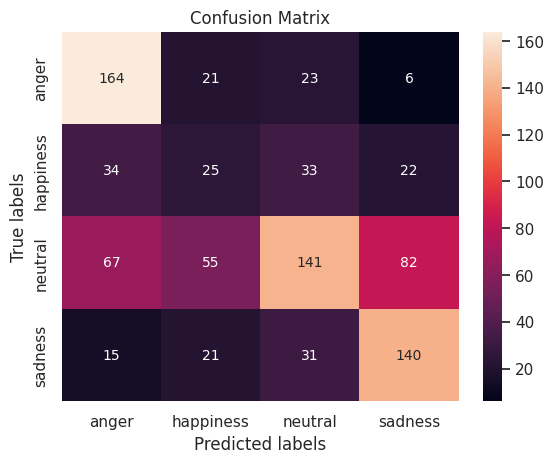


 Classification Report 
               precision    recall  f1-score   support

       anger       0.59      0.77      0.66       214
   happiness       0.20      0.22      0.21       114
     neutral       0.62      0.41      0.49       345
     sadness       0.56      0.68      0.61       207

    accuracy                           0.53       880
   macro avg       0.49      0.52      0.50       880
weighted avg       0.54      0.53      0.53       880
 

Train Epoch: 10 [0/3610 (0%)]	Loss: 0.962526

Train Epoch: 10 [640/3610 (18%)]	Loss: 0.984200

Train Epoch: 10 [1280/3610 (35%)]	Loss: 0.955995

Train Epoch: 10 [1920/3610 (53%)]	Loss: 0.856743

Train Epoch: 10 [2560/3610 (70%)]	Loss: 1.245635

Train Epoch: 10 [3200/3610 (88%)]	Loss: 1.007514


Train set: Average loss: 0.0151


Train Accuracy: 2191/3610 (61%)


Test set: Average loss: 0.0172, Accuracy: 470/880 (53%)



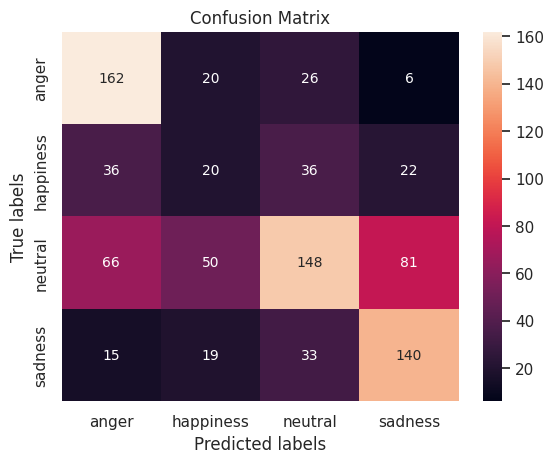


 Classification Report 
               precision    recall  f1-score   support

       anger       0.58      0.76      0.66       214
   happiness       0.18      0.18      0.18       114
     neutral       0.61      0.43      0.50       345
     sadness       0.56      0.68      0.61       207

    accuracy                           0.53       880
   macro avg       0.48      0.51      0.49       880
weighted avg       0.54      0.53      0.52       880
 



In [43]:
history_unfreeze = []
n_epoch_unfrz = 11
for epoch in range(1, n_epoch_unfrz):
#     exp_lr_scheduler.step(epoch)
    
    train_loss, train_acc = train(epoch, model)
    
    test_loss, test_acc = test(model)
    
    history_unfreeze.append([train_loss, train_acc, test_loss, test_acc])

In [44]:
history_df_unfrz = pd.DataFrame(history_unfreeze, columns=["train_loss", "train_acc", "test_loss", "test_acc"])

In [45]:
history_df_unfrz["epoch"] = [x for x in range(n_epoch, n_epoch + n_epoch_unfrz - 1)]

In [46]:
history_df_unfrz

train_loss  train_acc  test_loss  test_acc  epoch
0    0.016363         53   0.017687        50     51
1    0.016100         57   0.017513        52     52
2    0.016054         57   0.017439        53     53
3    0.015892         58   0.017435        53     54
4    0.015612         59   0.017326        53     55
5    0.015567         59   0.017254        53     56
6    0.015391         60   0.017271        53     57
7    0.015300         60   0.017232        53     58
8    0.015238         61   0.017307        53     59
9    0.015134         60   0.017176        53     60

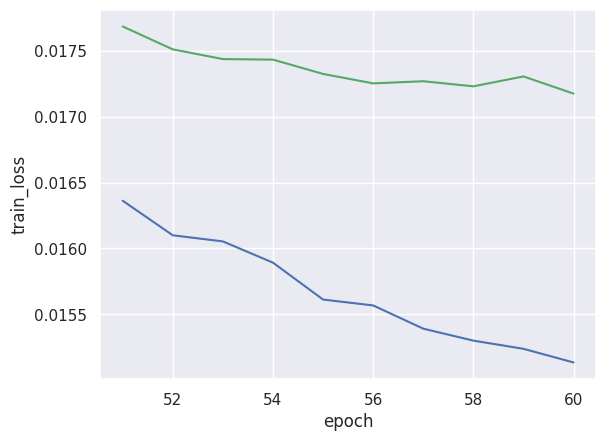

In [47]:
sns.set()
sns.lineplot(x='epoch', y='train_loss', data=history_df_unfrz, color='b')
sns.lineplot(x='epoch', y='test_loss', data=history_df_unfrz, color='g')
plt.show()
# plt.xticks()

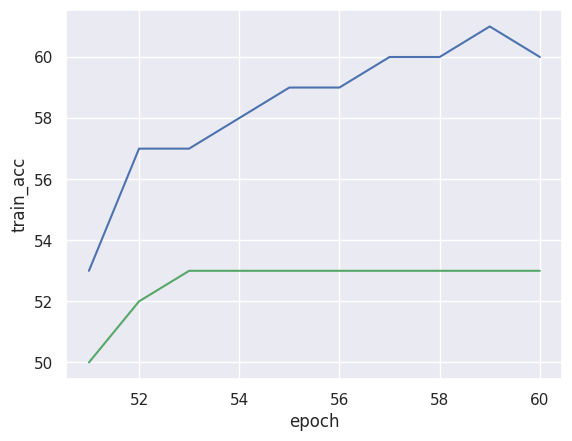

In [48]:
sns.set()
sns.lineplot(x='epoch', y='train_acc', data=history_df_unfrz, color='b')
sns.lineplot(x='epoch', y='test_acc', data=history_df_unfrz, color='g')
plt.show()
# plt.xticks()

In [49]:
torch.save(model, model_save_path + '/ResNet152_UnFreeze_Weights.pth')

In [50]:
history_total = pd.concat([history_df, history_df_unfrz])

In [51]:
history_total

train_loss  train_acc  test_loss  test_acc  epoch
0     0.021781         27   0.021549        42      1
1     0.021242         37   0.021044        47      2
2     0.020876         41   0.020879        44      3
3     0.020501         42   0.020346        46      4
4     0.020099         44   0.020083        45      5
5     0.019702         46   0.019475        50      6
6     0.019462         47   0.019217        49      7
7     0.019129         49   0.019263        46      8
8     0.019033         49   0.019296        46      9
9     0.018929         47   0.018929        48     10
10    0.018712         48   0.018520        51     11
11    0.018508         50   0.018506        50     12
12    0.018487         50   0.018319        51     13
13    0.018333         50   0.018516        49     14
14    0.018219         50   0.018318        50     15
15    0.018158         50   0.018008        52     16
16    0.018035         51   0.018245        50     17
17    0.018015         52   0.018190        50     18
18    0.017832         51   0.018084        50     19
19    0.017698         52   0.018136        49     20
20    0.017731         53   0.018300        47     21
21    0.017677         51   0.018061        49     22
22    0.017534         53   0.017738        52     23
23    0.017604         53   0.017969        50     24
24    0.017583         52   0.017929        51     25
25    0.017467         53   0.017713        52     26
26    0.017305         53   0.017645        53     27
27    0.017320         53   0.017697        52     28
28    0.017203         54   0.017681        52     29
29    0.017322         54   0.017669        52     30
30    0.017220         53   0.017585        52     31
31    0.017005         54   0.017737        51     32
32    0.016922         54   0.017657        53     33
33    0.016956         55   0.017402        54     34
34    0.016998         55   0.017713        51     35
35    0.016946         54   0.017484        53     36
36    0.016877         55   0.017497        53     37
37    0.016857         55   0.017341        53     38
38    0.016742         55   0.017758        51     39
39    0.016778         54   0.017833        52     40
40    0.016733         56   0.017769        51     41
41    0.016533         55   0.017544        52     42
42    0.016637         55   0.018095        47     43
43    0.016593         56   0.017156        55     44
44    0.016585         55   0.017519        53     45
45    0.016608         55   0.017649        51     46
46    0.016488         55   0.017715        52     47
47    0.016312         56   0.017457        53     48
48    0.016427         56   0.017445        52     49
49    0.016351         57   0.018301        45     50
0     0.016363         53   0.017687        50     51
1     0.016100         57   0.017513        52     52
2     0.016054         57   0.017439        53     53
3     0.015892         58   0.017435        53     54
4     0.015612         59   0.017326        53     55
5     0.015567         59   0.017254        53     56
6     0.015391         60   0.017271        53     57
7     0.015300         60   0.017232        53     58
8     0.015238         61   0.017307        53     59
9     0.015134         60   0.017176        53     60

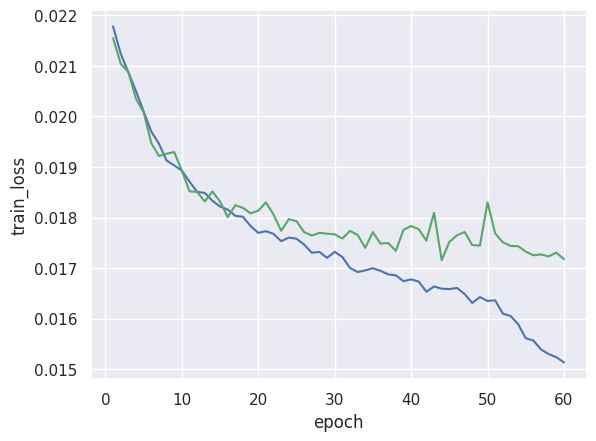

In [52]:
sns.set()
sns.lineplot(x='epoch', y='train_loss', data=history_total, color='b')
sns.lineplot(x='epoch', y='test_loss', data=history_total, color='g')
plt.show()
# plt.xticks()

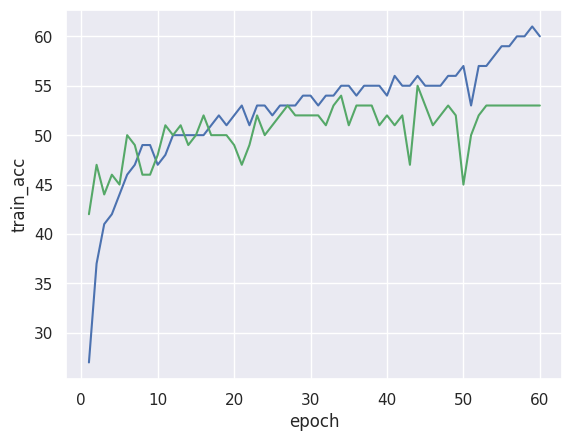

In [53]:
sns.set()
sns.lineplot(x='epoch', y='train_acc', data=history_total, color='b')
sns.lineplot(x='epoch', y='test_acc', data=history_total, color='g')
plt.show()
# plt.xticks()

Experiment with SGD

In [54]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
model = model.to(device)

In [55]:
for param in model.parameters():
    param.requires_grad = True

Train Epoch: 1 [0/3610 (0%)]	Loss: 0.885206

Train Epoch: 1 [640/3610 (18%)]	Loss: 1.036086

Train Epoch: 1 [1280/3610 (35%)]	Loss: 0.779711

Train Epoch: 1 [1920/3610 (53%)]	Loss: 0.864222

Train Epoch: 1 [2560/3610 (70%)]	Loss: 0.931719

Train Epoch: 1 [3200/3610 (88%)]	Loss: 0.855726


Train set: Average loss: 0.0151


Train Accuracy: 2216/3610 (61%)


Test set: Average loss: 0.0172, Accuracy: 474/880 (54%)



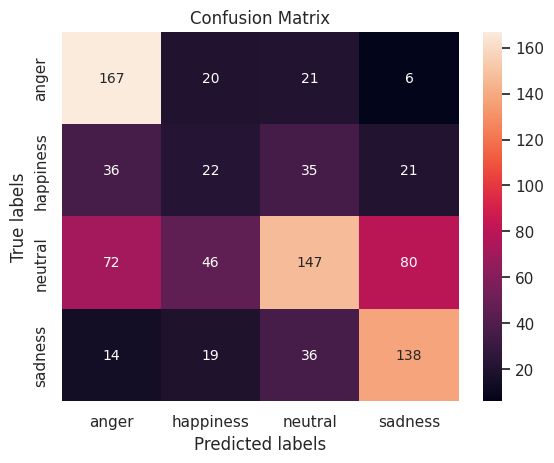


 Classification Report 
               precision    recall  f1-score   support

       anger       0.58      0.78      0.66       214
   happiness       0.21      0.19      0.20       114
     neutral       0.62      0.43      0.50       345
     sadness       0.56      0.67      0.61       207

    accuracy                           0.54       880
   macro avg       0.49      0.52      0.49       880
weighted avg       0.54      0.54      0.53       880
 

Train Epoch: 2 [0/3610 (0%)]	Loss: 0.958384

Train Epoch: 2 [640/3610 (18%)]	Loss: 0.948610

Train Epoch: 2 [1280/3610 (35%)]	Loss: 0.861278

Train Epoch: 2 [1920/3610 (53%)]	Loss: 0.855584

Train Epoch: 2 [2560/3610 (70%)]	Loss: 0.742556

Train Epoch: 2 [3200/3610 (88%)]	Loss: 1.015404


Train set: Average loss: 0.0148


Train Accuracy: 2252/3610 (62%)


Test set: Average loss: 0.0172, Accuracy: 475/880 (54%)



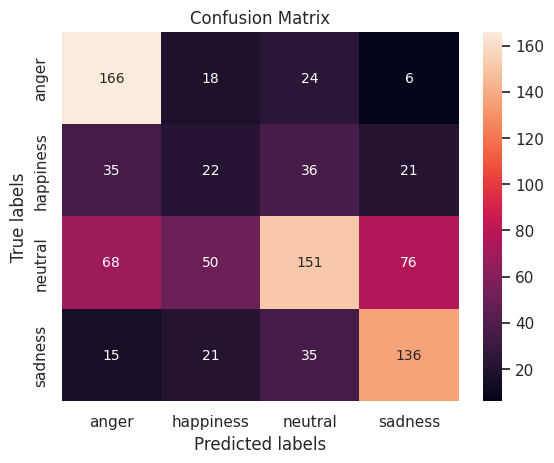


 Classification Report 
               precision    recall  f1-score   support

       anger       0.58      0.78      0.67       214
   happiness       0.20      0.19      0.20       114
     neutral       0.61      0.44      0.51       345
     sadness       0.57      0.66      0.61       207

    accuracy                           0.54       880
   macro avg       0.49      0.52      0.50       880
weighted avg       0.54      0.54      0.53       880
 

Train Epoch: 3 [0/3610 (0%)]	Loss: 0.885832

Train Epoch: 3 [640/3610 (18%)]	Loss: 1.000361

Train Epoch: 3 [1280/3610 (35%)]	Loss: 0.918801

Train Epoch: 3 [1920/3610 (53%)]	Loss: 1.000307

Train Epoch: 3 [2560/3610 (70%)]	Loss: 0.946692

Train Epoch: 3 [3200/3610 (88%)]	Loss: 0.920864


Train set: Average loss: 0.0148


Train Accuracy: 2260/3610 (63%)


Test set: Average loss: 0.0171, Accuracy: 482/880 (55%)



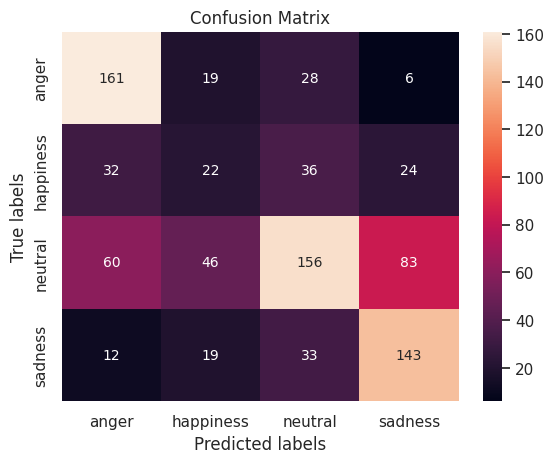


 Classification Report 
               precision    recall  f1-score   support

       anger       0.61      0.75      0.67       214
   happiness       0.21      0.19      0.20       114
     neutral       0.62      0.45      0.52       345
     sadness       0.56      0.69      0.62       207

    accuracy                           0.55       880
   macro avg       0.50      0.52      0.50       880
weighted avg       0.55      0.55      0.54       880
 

Train Epoch: 4 [0/3610 (0%)]	Loss: 0.968007

Train Epoch: 4 [640/3610 (18%)]	Loss: 1.041162

Train Epoch: 4 [1280/3610 (35%)]	Loss: 0.945486

Train Epoch: 4 [1920/3610 (53%)]	Loss: 0.871838

Train Epoch: 4 [2560/3610 (70%)]	Loss: 0.971005

Train Epoch: 4 [3200/3610 (88%)]	Loss: 0.936855


Train set: Average loss: 0.0147


Train Accuracy: 2279/3610 (63%)


Test set: Average loss: 0.0173, Accuracy: 468/880 (53%)



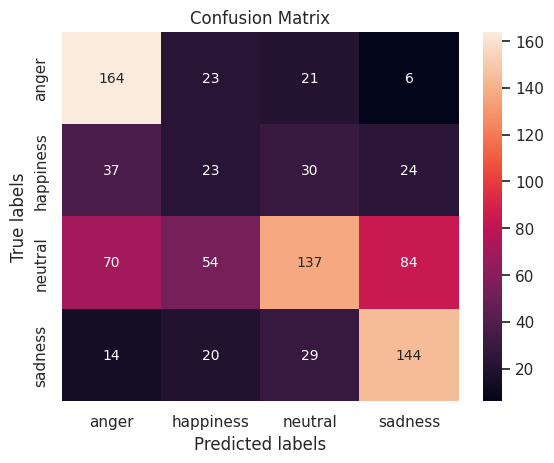


 Classification Report 
               precision    recall  f1-score   support

       anger       0.58      0.77      0.66       214
   happiness       0.19      0.20      0.20       114
     neutral       0.63      0.40      0.49       345
     sadness       0.56      0.70      0.62       207

    accuracy                           0.53       880
   macro avg       0.49      0.52      0.49       880
weighted avg       0.54      0.53      0.52       880
 

Train Epoch: 5 [0/3610 (0%)]	Loss: 0.956267

Train Epoch: 5 [640/3610 (18%)]	Loss: 0.874284

Train Epoch: 5 [1280/3610 (35%)]	Loss: 0.890910

Train Epoch: 5 [1920/3610 (53%)]	Loss: 0.952425

Train Epoch: 5 [2560/3610 (70%)]	Loss: 0.898383

Train Epoch: 5 [3200/3610 (88%)]	Loss: 0.963269


Train set: Average loss: 0.0145


Train Accuracy: 2300/3610 (64%)


Test set: Average loss: 0.0170, Accuracy: 476/880 (54%)



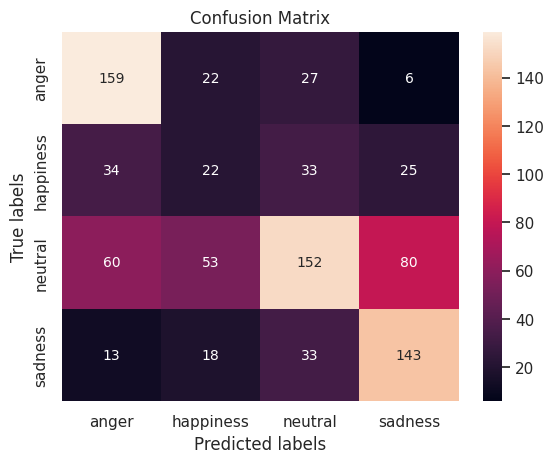


 Classification Report 
               precision    recall  f1-score   support

       anger       0.60      0.74      0.66       214
   happiness       0.19      0.19      0.19       114
     neutral       0.62      0.44      0.52       345
     sadness       0.56      0.69      0.62       207

    accuracy                           0.54       880
   macro avg       0.49      0.52      0.50       880
weighted avg       0.55      0.54      0.53       880
 

Train Epoch: 6 [0/3610 (0%)]	Loss: 0.870245

Train Epoch: 6 [640/3610 (18%)]	Loss: 1.015316

Train Epoch: 6 [1280/3610 (35%)]	Loss: 0.896679

Train Epoch: 6 [1920/3610 (53%)]	Loss: 0.788983

Train Epoch: 6 [2560/3610 (70%)]	Loss: 0.854686

Train Epoch: 6 [3200/3610 (88%)]	Loss: 0.908672


Train set: Average loss: 0.0146


Train Accuracy: 2266/3610 (63%)


Test set: Average loss: 0.0171, Accuracy: 474/880 (54%)



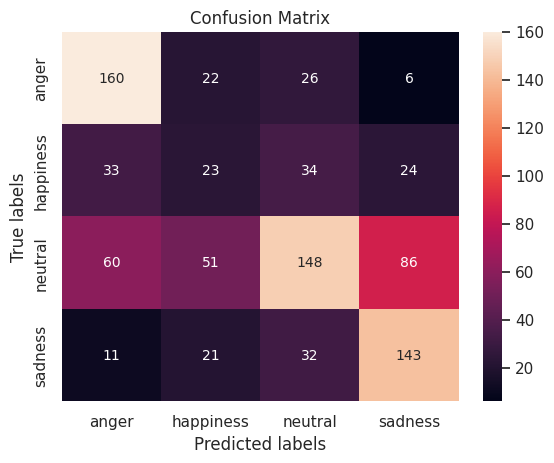


 Classification Report 
               precision    recall  f1-score   support

       anger       0.61      0.75      0.67       214
   happiness       0.20      0.20      0.20       114
     neutral       0.62      0.43      0.51       345
     sadness       0.55      0.69      0.61       207

    accuracy                           0.54       880
   macro avg       0.49      0.52      0.50       880
weighted avg       0.54      0.54      0.53       880
 

Train Epoch: 7 [0/3610 (0%)]	Loss: 0.894698

Train Epoch: 7 [640/3610 (18%)]	Loss: 0.879397

Train Epoch: 7 [1280/3610 (35%)]	Loss: 1.044710

Train Epoch: 7 [1920/3610 (53%)]	Loss: 0.929378

Train Epoch: 7 [2560/3610 (70%)]	Loss: 0.964835

Train Epoch: 7 [3200/3610 (88%)]	Loss: 0.934901


Train set: Average loss: 0.0144


Train Accuracy: 2308/3610 (64%)


Test set: Average loss: 0.0173, Accuracy: 469/880 (53%)



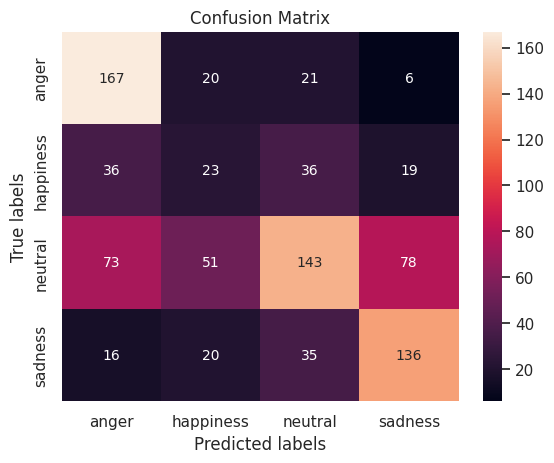


 Classification Report 
               precision    recall  f1-score   support

       anger       0.57      0.78      0.66       214
   happiness       0.20      0.20      0.20       114
     neutral       0.61      0.41      0.49       345
     sadness       0.57      0.66      0.61       207

    accuracy                           0.53       880
   macro avg       0.49      0.51      0.49       880
weighted avg       0.54      0.53      0.52       880
 

Train Epoch: 8 [0/3610 (0%)]	Loss: 0.948018

Train Epoch: 8 [640/3610 (18%)]	Loss: 1.013623

Train Epoch: 8 [1280/3610 (35%)]	Loss: 0.964580

Train Epoch: 8 [1920/3610 (53%)]	Loss: 0.994575

Train Epoch: 8 [2560/3610 (70%)]	Loss: 0.982095

Train Epoch: 8 [3200/3610 (88%)]	Loss: 0.861217


Train set: Average loss: 0.0145


Train Accuracy: 2306/3610 (64%)


Test set: Average loss: 0.0171, Accuracy: 475/880 (54%)



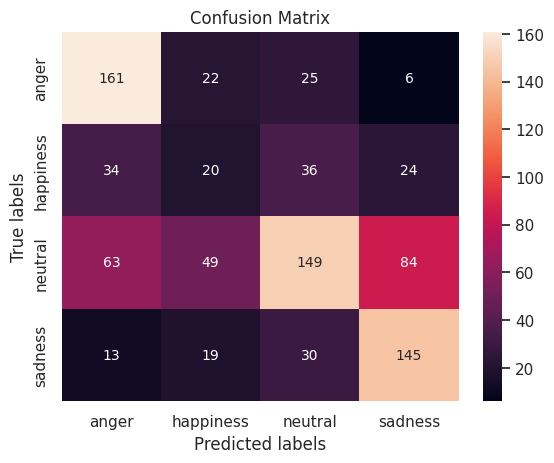


 Classification Report 
               precision    recall  f1-score   support

       anger       0.59      0.75      0.66       214
   happiness       0.18      0.18      0.18       114
     neutral       0.62      0.43      0.51       345
     sadness       0.56      0.70      0.62       207

    accuracy                           0.54       880
   macro avg       0.49      0.52      0.49       880
weighted avg       0.54      0.54      0.53       880
 

Train Epoch: 9 [0/3610 (0%)]	Loss: 0.864572

Train Epoch: 9 [640/3610 (18%)]	Loss: 1.006179

Train Epoch: 9 [1280/3610 (35%)]	Loss: 0.930155

Train Epoch: 9 [1920/3610 (53%)]	Loss: 0.913720

Train Epoch: 9 [2560/3610 (70%)]	Loss: 0.924510

Train Epoch: 9 [3200/3610 (88%)]	Loss: 0.888471


Train set: Average loss: 0.0143


Train Accuracy: 2371/3610 (66%)


Test set: Average loss: 0.0171, Accuracy: 481/880 (55%)



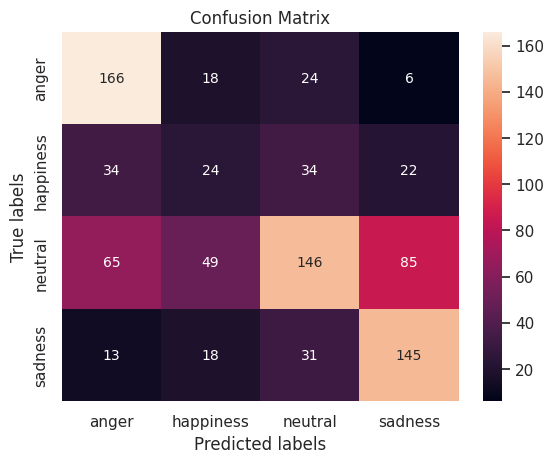


 Classification Report 
               precision    recall  f1-score   support

       anger       0.60      0.78      0.67       214
   happiness       0.22      0.21      0.22       114
     neutral       0.62      0.42      0.50       345
     sadness       0.56      0.70      0.62       207

    accuracy                           0.55       880
   macro avg       0.50      0.53      0.50       880
weighted avg       0.55      0.55      0.54       880
 

Train Epoch: 10 [0/3610 (0%)]	Loss: 0.962348

Train Epoch: 10 [640/3610 (18%)]	Loss: 1.056916

Train Epoch: 10 [1280/3610 (35%)]	Loss: 0.983356

Train Epoch: 10 [1920/3610 (53%)]	Loss: 0.884702

Train Epoch: 10 [2560/3610 (70%)]	Loss: 0.902256

Train Epoch: 10 [3200/3610 (88%)]	Loss: 0.833496


Train set: Average loss: 0.0142


Train Accuracy: 2314/3610 (64%)


Test set: Average loss: 0.0172, Accuracy: 473/880 (54%)



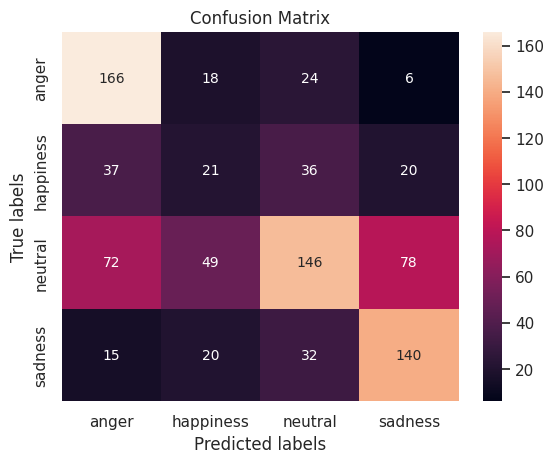


 Classification Report 
               precision    recall  f1-score   support

       anger       0.57      0.78      0.66       214
   happiness       0.19      0.18      0.19       114
     neutral       0.61      0.42      0.50       345
     sadness       0.57      0.68      0.62       207

    accuracy                           0.54       880
   macro avg       0.49      0.51      0.49       880
weighted avg       0.54      0.54      0.53       880
 



In [56]:
history_unfreeze_full = []
n_epoch_unfrz_full = 11
for epoch in range(1, n_epoch_unfrz_full):
#     exp_lr_scheduler.step(epoch)
    
    train_loss, train_acc = train(epoch, model)
    
    test_loss, test_acc = test(model)
    
    history_unfreeze_full.append([train_loss, train_acc, test_loss, test_acc])

In [57]:
history_df_unfrz_full = pd.DataFrame(history_unfreeze_full, columns=["train_loss", "train_acc", "test_loss", "test_acc"])

In [58]:
history_df_unfrz_full["epoch"] = [x for x in range(n_epoch_unfrz, n_epoch_unfrz + n_epoch_unfrz_full - 1)]

In [59]:
history_df_unfrz_full

train_loss  train_acc  test_loss  test_acc  epoch
0    0.015065         61   0.017218        53     11
1    0.014782         62   0.017177        53     12
2    0.014824         62   0.017064        54     13
3    0.014699         63   0.017277        53     14
4    0.014512         63   0.017050        54     15
5    0.014599         62   0.017067        53     16
6    0.014423         63   0.017280        53     17
7    0.014492         63   0.017056        53     18
8    0.014318         65   0.017132        54     19
9    0.014218         64   0.017173        53     20

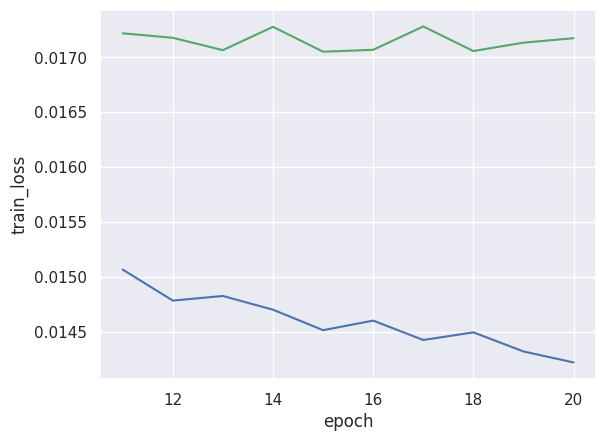

In [60]:
sns.set()
sns.lineplot(x='epoch', y='train_loss', data=history_df_unfrz_full, color='b')
sns.lineplot(x='epoch', y='test_loss', data=history_df_unfrz_full, color='g')
plt.show()
# plt.xticks()

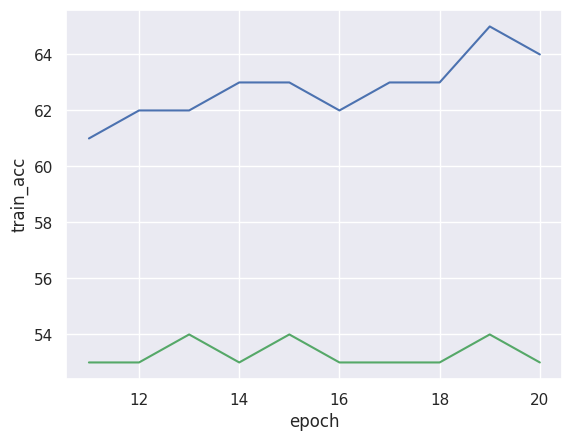

In [61]:
sns.set()
sns.lineplot(x='epoch', y='train_acc', data=history_df_unfrz_full, color='b')
sns.lineplot(x='epoch', y='test_acc', data=history_df_unfrz_full, color='g')
plt.show()
# plt.xticks()